In [ ]:
################################ EDA IMPORTS ###################################
%matplotlib inline
import pandas as pd 
import pandas_profiling # Quick Data Analysis
import numpy as np # Linear Algebra lib
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objs as go # interactive low-level plotting lib https://plot.ly/python/
import plotly.express as px #high-level api wrapper for plotly https://plot.ly/python/plotly-express/#visualize-distributions
# ---------------- Plot libs settings ------------- #
# Pick style of Matplolib plots 
# Different style sheets:-> https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
# Configure Seaborn Asthetics: -> https://seaborn.pydata.org/tutorial/aesthetics.html?highlight=style
plt.style.use('seaborn-darkgrid')
sns.set(context='notebook', style='darkgrid', palette='colorblind')
# Seting a universal figure size 
plt.rcParams['figure.figsize'] = (10, 6)

# ---------------- Pandas settings ------------- #
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

################################################################################
############################# Ignore the warnings ##############################
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

################################################################################

In [2]:
def download_raw_data_from_s3():
    !rm -rf '../datasets/dirty-data'
    #!rm -rf '../datasets/clean-data'
    !mkdir -p '../datasets/dirty-data'
    #!mkdir -p '../datasets/clean-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_kakao_2019-08-26_02PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_psn_2019-08-26_01PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_steam_2019-08-26_01PM.csv' -P '../datasets/dirty-data'
    !wget 'https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_xbox_2019-08-26_02PM.csv' -P '../datasets/dirty-data'
    
download_raw_data_from_s3()

--2019-08-29 05:24:46--  https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.84.64
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.84.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16665366 (16M) [text/csv]
Saving to: ‘../datasets/dirty-data/pubg_stats.csv’

pubg_stats.csv      100%[===================>]  15.89M  91.6MB/s    in 0.2s    

2019-08-29 05:24:46 (91.6 MB/s) - ‘../datasets/dirty-data/pubg_stats.csv’ saved [16665366/16665366]

--2019-08-29 05:24:46--  https://project-pubg.s3.us-east-2.amazonaws.com/dirty-data/pubg_stats_kakao_2019-08-26_02PM.csv
Resolving project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)... 52.219.84.64
Connecting to project-pubg.s3.us-east-2.amazonaws.com (project-pubg.s3.us-east-2.amazonaws.com)|52.219.84.64|:443... conn

## Project PUBG 🤖💣💥🔫🤖 


### So, where we droppin' boys and girls?
PUBG or Player Unknown Battlegrounds is a battle-royale style game where at the beginning of the play, nearly 100 people parachute onto an island without any equipment. In order to win the game, you need to scavenge for weapons and available equipment to eliminate the other people and survive to the end. The game also restricts player in Hunger Game style by reducing the playable are in map after a some amount of fixed time is passed. 

### Objective

**Defining the problem:** The problem we have is, there is not set guide or strategy to improve player performance in PUBG, should your play style be stealth like a ninja and sneak upon unsuspecting players, or by camping in one spot and hide your way into victory, or snipe like assassin, or do you need to be aggressive and play like Rambo?  

**Solution:** Is to create a web application that allows players to improve their strategy by considering *What-if* scenarios as MVP.

**Restrictions:** To keep the project simple and meaningful, we would need to keep game mode, and map types restricted, remove any outliers (aka cheaters) and players that logged-in but didn't play. 


### Data Mining

The team at [PUBG](https://www.pubg.com/) has made official game data available for the public to explore and scavenge outside of "The Blue Circle." 

Process:

- Using [PUBG DEVELOPER API](https://documentation.pubg.com/) we can mine the necessary data of player matches from different **platforms**:
    - **steam**
    - **psn**
    - **xbox**
    - **kakao**
    
- Using `/samples` API endpoint we will collect sample matches from each platform, merge them, and remove any identifiable information of player like their PUBG IGN, add some features for feature engineering, with Quick EDA.


![](https://d.newsweek.com/en/full/854048/pubg-logo.jpg)


## [Contents](#)


### [Data Dictionary](#Data-Dictionary)

### [Extract, Transform, Load](#Extract,-Transform,-Load)
  - #### [Load](#Load)
  - #### [Transform](#Transform)
  
### [Train, Validate, Test Split](#Train,-Validate,-Test-Split)

### [EDA and Data Wrangling](#EDA-and-Data-Wrangling)
 - #### [Descriptive Statistics](#Descriptive-Statistics)
 - #### [Single Variable Analysis](#Single-Variable-Analysis)
 - #### [Pairwise Analysis](#Pairwise-Analysis)
 - #### [Correlations](#Correlations)

### [Baseline](#Baseline)
 - #### [Mean](#Mean)
 - #### [Linear Regression](#Linear-Regression)
 - #### [Random Forest](#Random-Forest)

###  [Data Dictionary](#Contents)


Below is data description from [`matches` API endpoint documentation](https://documentation.pubg.com/en/matches-endpoint.html)

- `DBNOs` - Down But Not Out - Number of enemy players knocked.
- `assists` - Number of enemy players this player damaged that were killed by teammates.
- `boosts` - Number of boost items used (i.e. energy drinks - which increases player's boost by 40, granting health regeneration, increase movement and speed.)
- `damageDealt` - Total damage dealt. Note: Self inflicted damage is subtracted.
- `deathType` - If player killed another player or by their teammates or self-inflicted death (i.e. suicide) ⚠️ **NOTE: Causes leakage, as player is alive than they by default won the game, something that can be known only after the game.**
- `duration` - Duration of match in seconds.
- `gameMode` - String identifying the game mode that the data comes from. The standard modes are:
    -`solo` or `solo-fpp` (FPP - First Person Player)
    - `duo` or `duo-fpp`
    - `squad` or `squad-fpp`
    and other modes are from events or custom matches.
- `headshotKills` - Number of enemy players killed with headshots.
- `heals` - Number of healing items used.
- `killPlace` - Ranking in match of number of enemy players killed, min. 1, max. 130. ⚠️ **NOTE: Using it would cause target leakage as this stat. is collected after gameplay.**
- `killStreaks` - Max number of enemy players killed in a short amount of time.
- `kills` - Number of enemy players killed.
- `longestKill` - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- `mapName` - There are 4 main type of maps:
    - Erangel 
    - Desert (Miramar)
    - Savage (Sanhok)
    - Snow (Vikendi) 
**Any other maps, like `Training`, or custom ones should be removed**.
- `matchId` - ID to identify match. There are no matches that are in both the training and testing set. 
- `name` - PUGB player id 🚫 **this would be removed to preserve player anonymity**
- `playerId` - id of the player 
- `revives` - Number of times this player revived teammates.
- `rideDistance` - Total distance traveled in vehicles measured in meters.
- `roadKills` - Number of kills while in a vehicle.
- `swimDistance` - Total distance traveled by swimming measured in meters.
- `teamKills` - Number of times this player killed a teammate.
- `timeSurvived` - Amount of time survived measured in seconds
- `vehicleDestroys` - Number of vehicles destroyed.
- `walkDistance` - Total distance traveled on foot measured in meters.
- `weaponsAcquired` - Number of weapons picked up.
- `winPlace` - This player's placement in the match, which would be our target.

### [Extract, Transform, Load](#Contents)

In [3]:
#################################### CUSTOM API IMPORTS #######################
import sys, os
sys.path.insert(len(sys.path)-1, os.path.dirname(os.getcwd()))
from pubg import helper
from pubg import eda
###############################################################################

#### [Load](#Contents)

In [4]:
dirty_data_dir = '../datasets/dirty-data'

dfs = []
for file in os.listdir(dirty_data_dir):
    file_path = os.path.join(dirty_data_dir, file)
    df = helper.load_dataset(file_path, verbose=True)
    dfs.append(df)

Memory usage of dataframe is 13.22 MB
Memory usage after optimization is: 4.96 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
        DF pubg_stats_xbox_2019-08-26_02PM.csv: (61874, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 17.83 MB
Memory usage after optimization is: 6.69 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
        DF pubg_stats.csv: (83480, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 26.57 MB
Memory usage after optimization is: 10.08 MB
Decreased by 62.1%

        -------------------- SHAPE ---------------------
        DF pubg_stats_steam_2019-08-26_01PM.csv: (124395, 28)
        ------------------------------------------------
        
Memory usage of dataframe is 10.61 MB
Memory usage after optimization is: 3.98 MB
Decreased by 62.5%

        -------------------- SHAPE ---------------------
    

####   <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Steam_icon_logo.svg/1200px-Steam_icon_logo.svg.png' width=32 height=32 align='left'> 

In [5]:
# Individual shapes are: 
dfs[0].shape, dfs[3].shape

((61874, 28), (49654, 28))

In [6]:
steam = pd.concat([dfs[0], dfs[3]], ignore_index=True, verify_integrity=True)


# Assert total rows 8,3480 + 124,395 = 207,875
assert dfs[0].shape[0] + dfs[3].shape[0] == steam.shape[0]
# Assert total cols 28 == 28
assert dfs[0].shape[1] == steam.shape[1]

steam.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,0,0,0.0000,byplayer,1896,duo,0,0,81,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,BUD211,xbox,account.51fb110f057b45febfadbd70652149a7,0,0.0,0,0.0,0,167.75,0,0.000,0,44
1,0,0,0,0.0000,byplayer,1896,duo,0,0,83,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,Zoowapp,xbox,account.2457bac6bf314d5596d173b97eaa27a7,0,0.0,0,0.0,0,124.50,0,57.375,1,44
2,0,0,2,130.3750,byplayer,1896,duo,0,3,35,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,Dirk Digler 811,xbox,account.92b271e386ee4097b2af75347a516610,0,7272.0,0,0.0,0,1546.00,0,2648.000,4,6
3,0,0,2,100.0000,byplayer,1896,duo,0,1,26,1,1,6.101562,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,XXXManzyXXX,xbox,account.fbd29ae05d634609a005a7a4962f2e92,1,2494.0,0,0.0,0,1126.00,0,1731.000,4,17
4,1,0,0,67.4375,byplayer,1896,duo,0,0,61,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,NINJA aka KEGAN,xbox,account.22700517c6dd4e89bec3c8eef28eeb14,0,0.0,0,0.0,0,322.75,0,272.250,5,29


In [7]:
steam.tail()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
111523,0,0,0,0.0000,byplayer,1856,squad,0,0,49,0,0,0.000000,Desert_Main,9648a897-b7bd-4453-bdeb-7100038ef19b,Thraxx_slimey,psn,account.e92ab6d5fcbc4b52b5a68f667644cc86,0,1625.0,0,0.0,0,1097.000,1,2244.0000,12,12
111524,0,0,1,70.0625,byplayer,1856,squad,0,0,46,0,0,0.000000,Desert_Main,9648a897-b7bd-4453-bdeb-7100038ef19b,MayronChui1616,psn,account.b521cb73a65544b1b66e030dd0d6e14d,0,0.0,0,0.0,0,1387.000,0,3868.0000,3,9
111525,1,0,0,100.0000,byplayer,1856,squad,1,0,39,1,1,2.337891,Desert_Main,9648a897-b7bd-4453-bdeb-7100038ef19b,NazarenoLlambay,psn,account.76cbb93e4c2b42c2880297ce6eba8eae,0,0.0,0,0.0,0,230.750,0,101.0625,4,25
111526,0,0,0,0.0000,byplayer,1856,squad,0,0,68,0,0,0.000000,Desert_Main,9648a897-b7bd-4453-bdeb-7100038ef19b,Dom88Pereira,psn,account.5cf7f380c067453ebb9128cf922607fe,0,0.0,0,0.0,0,242.375,0,193.5000,1,22
111527,2,1,1,173.8750,byplayer,1856,squad,1,0,19,2,2,6.464844,Desert_Main,9648a897-b7bd-4453-bdeb-7100038ef19b,IammGeoo,psn,account.5922a069cd8d47489a893267502a4514,0,0.0,0,0.0,0,768.000,0,744.0000,6,18


In [8]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111528 entries, 0 to 111527
Data columns (total 28 columns):
DBNOs              111528 non-null int8
assists            111528 non-null int8
boosts             111528 non-null int8
damageDealt        111528 non-null float16
deathType          111528 non-null object
duration           111528 non-null int16
gameMode           111528 non-null object
headshotKills      111528 non-null int8
heals              111528 non-null int8
killPlace          111528 non-null int8
killStreaks        111528 non-null int8
kills              111528 non-null int8
longestKill        111528 non-null float16
mapName            111528 non-null object
matchId            111528 non-null object
name               111528 non-null object
platform           111528 non-null object
playerId           111528 non-null object
revives            111528 non-null int8
rideDistance       111528 non-null float16
roadKills          111528 non-null int8
swimDistance       111528

#### <img src='https://upload.wikimedia.org/wikipedia/commons/f/f2/PlayStation_Network_logo.png' width=180 height=50 align='left'>

In [9]:
psn = dfs[2]
psn.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,2,0,0,104.9375,byplayer,1790,duo-fpp,0,1,86,0,0,0.0,Baltic_Main,c12d2fc1-e7e9-483a-be78-9798d5207648,Scarface046,steam,account.3aa8339838f147e49255096223bb20ae,0,0.0,0,0.0,0,170.375,0,209.2500,1,45
1,0,0,0,0.0000,byplayer,1790,duo-fpp,0,0,49,0,0,0.0,Baltic_Main,c12d2fc1-e7e9-483a-be78-9798d5207648,krycha119,steam,account.a673e2b244624d8480de17c7135692b9,0,0.0,0,0.0,0,1028.000,0,3238.0000,4,16
2,0,0,0,98.6875,byplayer,1790,duo-fpp,0,0,80,0,0,0.0,Baltic_Main,c12d2fc1-e7e9-483a-be78-9798d5207648,ilay675,steam,account.a28739c1d25b4e3c9494b19bb7b52c8b,0,0.0,0,0.0,0,189.000,0,91.0625,2,43
3,0,0,2,42.1250,byplayer,1790,duo-fpp,0,0,79,0,0,0.0,Baltic_Main,c12d2fc1-e7e9-483a-be78-9798d5207648,DZJACPB29,steam,account.b0d78f5a910e4b5aaf006b98fd083e36,0,0.0,0,0.0,0,217.625,0,78.6250,3,42
4,0,0,1,0.0000,byplayer,1790,duo-fpp,0,0,57,0,0,0.0,Baltic_Main,c12d2fc1-e7e9-483a-be78-9798d5207648,StNns,steam,account.334f7ecc3ddf4734a8f7a718a216662b,0,1014.5,0,0.0,0,737.000,0,704.0000,8,25


In [10]:
psn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124395 entries, 0 to 124394
Data columns (total 28 columns):
DBNOs              124395 non-null int8
assists            124395 non-null int8
boosts             124395 non-null int8
damageDealt        124395 non-null float16
deathType          124395 non-null object
duration           124395 non-null int16
gameMode           124395 non-null object
headshotKills      124395 non-null int8
heals              124395 non-null int8
killPlace          124395 non-null int8
killStreaks        124395 non-null int8
kills              124395 non-null int8
longestKill        124395 non-null float16
mapName            124395 non-null object
matchId            124395 non-null object
name               124395 non-null object
platform           124395 non-null object
playerId           124395 non-null object
revives            124395 non-null int8
rideDistance       124395 non-null float16
roadKills          124395 non-null int8
swimDistance       124395

#### <img src='https://upload.wikimedia.org/wikipedia/commons/f/f9/Xbox_one_logo.svg' width=32 height=32 align='left'>

In [11]:
xbox = dfs[4]
xbox.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,0,1,0.00,byplayer,1371,squad,0,3,53,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,LG-U-Plus2,kakao,account.dd9d4a11e0844488bc5109f1e9741a74,0,0.0,0,0.0,0,755.50,0,2340.00,4,11
1,0,0,0,0.00,byplayer,1371,squad,0,0,44,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,dyd0418,kakao,account.6614ff7dbb8d487f8f7296b9843feb94,0,1570.0,0,0.0,0,1137.00,0,2462.00,2,6
2,0,0,0,0.00,byplayer,1371,squad,0,0,69,0,0,0.000000,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,yonrok1213,kakao,account.31be4b8dd94a4a129466dec9b77e32fe,0,0.0,0,0.0,0,291.75,0,430.50,3,22
3,1,0,0,100.00,byplayer,1371,squad,0,0,34,1,1,13.781250,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,KangamanHu,kakao,account.bdc44da7053641ea9ec84dff7b48d405,0,0.0,0,0.0,0,259.00,0,356.75,2,23
4,2,0,4,376.75,byplayer,1371,squad,0,1,7,1,4,14.898438,Savage_Main,f2aef6d2-aece-4ffa-82a7-d5e175f0a885,lwj0210,kakao,account.bd25f4b938ec4354b8e9640214bea226,1,0.0,0,0.0,0,753.00,0,1483.00,10,12


In [12]:
xbox.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100843 entries, 0 to 100842
Data columns (total 28 columns):
DBNOs              100843 non-null int8
assists            100843 non-null int8
boosts             100843 non-null int8
damageDealt        100843 non-null float16
deathType          100843 non-null object
duration           100843 non-null int16
gameMode           100843 non-null object
headshotKills      100843 non-null int8
heals              100843 non-null int8
killPlace          100843 non-null int8
killStreaks        100843 non-null int8
kills              100843 non-null int8
longestKill        100843 non-null float16
mapName            100843 non-null object
matchId            100843 non-null object
name               100843 non-null object
platform           100843 non-null object
playerId           100843 non-null object
revives            100843 non-null int8
rideDistance       100843 non-null float16
roadKills          100843 non-null int8
swimDistance       100843

#### <img src='https://upload.wikimedia.org/wikipedia/commons/d/de/Kakao_CI_yellow.svg' width=64 height=32 align='left'>

In [13]:
kakao = dfs[1]
kakao.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,name,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,1,2,0,118.5625,byplayer,1787,squad,0,0,35,1,1,8.742188,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,CoreyMrT,steam,account.e8dec15d50f44b33b5ecbd77b4498efe,0,0.0,0,0.0,0,375.25,0,417.75,4,22
1,0,0,5,166.0000,byplayer,1787,squad,0,1,11,1,2,120.562500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,MichaelTX254,steam,account.83e9e5bd6566499da1cc5f185c43eb74,1,3156.0,0,0.0,0,1421.00,0,2608.00,5,5
2,2,1,4,266.0000,byplayer,1787,squad,0,5,7,2,3,23.062500,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,Dr_Matasanos,steam,account.97dc2011adfe4c75879743f83903fb59,0,2846.0,0,0.0,0,1400.00,0,3002.00,4,6
3,1,5,3,417.2500,byzone,1787,squad,0,0,5,2,3,270.500000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,Pray_GM,steam,account.3d478dcf49f449b3a42e84063a621074,0,1302.0,0,0.0,0,1549.00,1,2676.00,7,1
4,1,0,0,18.0000,byplayer,1787,squad,0,0,84,0,0,0.000000,Baltic_Main,495f2895-a0a2-41a3-9faa-e64056f6364c,ComicBooksPlus,steam,account.534f2b758b01409681fe3c4313ad270a,0,0.0,0,0.0,0,301.50,0,530.00,3,24


In [14]:
kakao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83480 entries, 0 to 83479
Data columns (total 28 columns):
DBNOs              83480 non-null int8
assists            83480 non-null int8
boosts             83480 non-null int8
damageDealt        83480 non-null float16
deathType          83480 non-null object
duration           83480 non-null int16
gameMode           83480 non-null object
headshotKills      83480 non-null int8
heals              83480 non-null int8
killPlace          83480 non-null int8
killStreaks        83480 non-null int8
kills              83480 non-null int8
longestKill        83480 non-null float16
mapName            83480 non-null object
matchId            83480 non-null object
name               83480 non-null object
platform           83480 non-null object
playerId           83480 non-null object
revives            83480 non-null int8
rideDistance       83480 non-null float16
roadKills          83480 non-null int8
swimDistance       83480 non-null float16
teamKi

#### [Transform](#Contents)

#### Combine/Merge them

In [15]:
complete_df = pd.concat([steam, psn, xbox, kakao], ignore_index=True, verify_integrity=True)

# Assert shape

## Total Rows
##  207875 + 49654 + 61874 + 100843 == 420,246
assert (steam.shape[0] + psn.shape[0] + xbox.shape[0] + kakao.shape[0]) == complete_df.shape[0]

## Cols should be same
assert 28 == complete_df.shape[1]

complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420246 entries, 0 to 420245
Data columns (total 28 columns):
DBNOs              420246 non-null int8
assists            420246 non-null int8
boosts             420246 non-null int8
damageDealt        420246 non-null float16
deathType          420246 non-null object
duration           420246 non-null int16
gameMode           420246 non-null object
headshotKills      420246 non-null int8
heals              420246 non-null int8
killPlace          420246 non-null int8
killStreaks        420246 non-null int8
kills              420246 non-null int8
longestKill        420246 non-null float16
mapName            420246 non-null object
matchId            420246 non-null object
name               420246 non-null object
platform           420246 non-null object
playerId           420246 non-null object
revives            420246 non-null int8
rideDistance       420246 non-null float16
roadKills          420246 non-null int8
swimDistance       420246

In [16]:
complete_df.groupby('platform').size()

platform
kakao    100843
psn       49654
steam    207875
xbox      61874
dtype: int64

#### Anonymize by removing user name 🙈 

In [17]:
# Clean Player Id column
complete_df['playerId'] = complete_df['playerId'].str.lower().str.strip('account.')
# Drop player name columns
complete_df = complete_df.drop(columns=['name'])
complete_df.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace
0,0,0,0,0.0000,byplayer,1896,duo,0,0,81,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,xbox,51fb110f057b45febfadbd70652149a7,0,0.0,0,0.0,0,167.75,0,0.000,0,44
1,0,0,0,0.0000,byplayer,1896,duo,0,0,83,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,xbox,2457bac6bf314d5596d173b97eaa27a7,0,0.0,0,0.0,0,124.50,0,57.375,1,44
2,0,0,2,130.3750,byplayer,1896,duo,0,3,35,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,xbox,92b271e386ee4097b2af75347a516610,0,7272.0,0,0.0,0,1546.00,0,2648.000,4,6
3,0,0,2,100.0000,byplayer,1896,duo,0,1,26,1,1,6.101562,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,xbox,fbd29ae05d634609a005a7a4962f2e92,1,2494.0,0,0.0,0,1126.00,0,1731.000,4,17
4,1,0,0,67.4375,byplayer,1896,duo,0,0,61,0,0,0.000000,Desert_Main,974c2b5f-b585-4c33-9e65-81083017ce90,xbox,22700517c6dd4e89bec3c8eef28eeb14,0,0.0,0,0.0,0,322.75,0,272.250,5,29


#### Engineer ⚒️ Target

Using **Min-Max Scaler** we can scale the rankings of players into chances of winning.

- `winPlacePerc` : This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace.

There is also another benefit by scaling we can remove any players that never played or logged out or won the game by timeout as they were only player in the game. 

In [18]:
complete_df['maxPlace'] = complete_df.groupby('matchId')['winPlace'].transform('max')
complete_df['minPlace'] = complete_df.groupby('matchId')['winPlace'].transform('min')
complete_df['winPlacePerc'] = 1 - ((complete_df['winPlace'] - complete_df['minPlace'])/(complete_df['maxPlace'] - complete_df['minPlace']))
complete_df.sample(10)

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc
233349,3,1,6,525.000000,byplayer,1781,duo,2,14,8,2,4,166.250000,Baltic_Main,f87ef367-65f8-4f1c-b928-981f1be93a0e,steam,f7d20c7974814f4d8c7cecfc20954cb9,0,1980.0,0,10.09375,0,1685.000,0,4444.000,4,5,48,1,0.914894
106814,0,0,0,29.296875,byplayer,1967,duo,0,0,85,0,0,0.000000,Erangel_Main,262905d9-e209-4326-8f51-5e2c0da685b6,psn,2b66eb0433d147a8842566cf7d943a1,0,0.0,0,0.00000,0,163.875,0,73.875,1,42,48,1,0.127660
11583,0,0,0,0.000000,byplayer,1857,squad,0,0,71,0,0,0.000000,Erangel_Main,bad51c6f-9d9a-44d8-b7bd-1f408d4b78ca,xbox,78cf624d528e4ab48bf6c287e6529328,0,0.0,0,0.00000,0,195.875,0,0.000,0,25,25,1,0.000000
186444,2,0,2,103.625000,byplayer,1895,squad,0,8,19,1,2,12.289062,Desert_Main,e366c916-6ac3-4db9-8135-9a23ad7f6290,steam,6b505364a48c4a4c81df8765de025180,0,4400.0,0,0.00000,0,1308.000,0,2028.000,4,17,27,1,0.384615
363262,1,0,1,95.125000,byplayer,1387,squad,0,0,45,1,1,4.890625,Savage_Main,a9def4a0-5334-44cf-b322-f2a7f3ac021e,steam,b66fd91c4b040cc9dab58c8544d932b,1,0.0,0,0.00000,0,243.625,0,160.625,3,23,25,1,0.083333
266482,1,0,0,25.156250,byplayer,1465,squad,0,0,35,1,1,42.562500,Savage_Main,cfeaf3b4-e17e-4e23-907a-2a1882b2e3f4,kakao,e7d8a87a44b24dea8174654bd764c2ad,0,0.0,0,0.00000,0,373.000,0,233.375,1,18,29,1,0.392857
78620,2,0,3,342.000000,byplayer,1863,squad,0,2,17,1,2,15.179688,Desert_Main,8b8381f2-5c3d-4423-b69d-caaa433b08eb,psn,8db710ce7a4faf8e1cfb63006c2bb9,1,0.0,0,0.00000,0,1093.000,0,1474.000,8,17,25,1,0.333333
105991,1,1,2,322.000000,alive,1394,squad,0,3,10,1,2,49.718750,Savage_Main,1e1865d7-048f-4697-b77b-4469a12d0a8b,psn,8efd265906164a9b8c20cfbc96bc5697,0,0.0,0,0.00000,0,1395.000,0,3436.000,11,1,27,1,1.000000
204015,1,0,1,72.937500,byplayer,1767,duo-fpp,0,3,29,1,1,19.906250,DihorOtok_Main,e7e02689-f781-4065-8a0f-e0f5caa73091,steam,7cdefaa3fa99403899ab8822b850d52b,0,0.0,0,0.00000,0,605.000,0,547.000,3,20,46,1,0.577778
229643,1,1,5,252.750000,byzone,1831,squad,0,7,34,0,0,0.000000,Baltic_Main,4f256335-306b-41fe-a5e3-be14bb10d6b6,steam,34f74d03848546698007a66e5d0ca52,1,6676.0,0,0.00000,0,1658.000,0,2070.000,7,4,25,1,0.875000


####  Check for ❓ Missing Values 

Check if there are missing values in `winPlacePerc`, and investigate those players, that have missing **NaNs**:

In [19]:
anomalies = complete_df[complete_df['winPlacePerc'].isna()]
anomalies.sample(15, random_state=0)

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc
301613,0,0,0,0.00,logout,1020,solo,0,0,17,0,0,0.0,Range_Main,e0b5d27c-6aa0-4575-ac25-cf34f0a92bd1,kakao,70ca07f8c66a4a8b93041088f6862b2d,0,0.0,0,0.0,0,28.234375,0,0.0,0,18,18,18,NaN
253012,0,0,0,0.00,logout,1475,solo,0,0,15,0,0,0.0,Range_Main,bd0ece05-0694-45f0-816a-0103709f79a4,kakao,f235eab80c94484b81a4b5a44d833a9,0,0.0,0,0.0,0,69.375000,0,0.0,4,18,18,18,NaN
329653,0,0,0,0.00,logout,1567,solo,0,0,18,0,0,0.0,Range_Main,944db6fa-9e08-43e1-9d9d-aaf524f32d63,kakao,d8c9865329ab42a191913238f4cd62f,0,0.0,0,0.0,0,80.750000,0,0.0,1,19,19,19,NaN
328103,0,0,0,499.25,logout,1669,solo,0,0,8,0,0,0.0,Range_Main,6ef9e127-4a81-44a2-b4b2-907e1c4e1f73,kakao,37064bc9d53c4730aef8a35e4dadf99,0,0.0,0,0.0,0,428.000000,0,0.0,2,18,18,18,NaN
179315,0,0,0,99.00,logout,1576,solo,0,0,3,0,0,0.0,Range_Main,1defd014-386d-4417-8121-5369ace5064d,steam,512f5eb71f724e7e85256906697af464,0,0.0,0,0.0,0,763.500000,0,0.0,5,20,20,20,NaN
276884,0,0,0,0.00,logout,1151,solo,0,0,9,0,0,0.0,Range_Main,8a256587-cb36-4a39-b387-0bca8317b425,kakao,39bdfda318e64c7aa344f1071153372,0,0.0,0,0.0,0,370.750000,0,0.0,2,18,18,18,NaN
265918,0,0,0,0.00,logout,624,solo,0,0,12,0,0,0.0,Range_Main,110380e8-049a-4c6c-86a1-a2ea74a23634,kakao,b7186d89d13a4cd5ad53cdc166f53fa5,0,0.0,0,0.0,0,95.062500,0,0.0,0,16,16,16,NaN
265915,0,0,0,127.00,logout,624,solo,0,0,3,0,0,0.0,Range_Main,110380e8-049a-4c6c-86a1-a2ea74a23634,kakao,6a3ba6ec81844e3a73b4f2303bf0d85,0,0.0,0,0.0,0,581.500000,0,0.0,2,16,16,16,NaN
305510,0,0,0,198.00,logout,1755,solo,0,0,17,0,0,0.0,Range_Main,ada8e88e-3ba4-40de-8d89-f0c507c34a89,kakao,4c61a973ccfe44aa8734faca58071b41,0,0.0,0,0.0,0,205.125000,0,0.0,5,19,19,19,NaN
261691,0,0,0,393.25,logout,1127,solo,0,4,3,0,0,0.0,Range_Main,3866df29-7927-485b-a641-45f1968b2024,kakao,983b522f68fe439da272ec4095b50e62,0,0.0,0,0.0,0,917.000000,0,0.0,1,17,17,17,NaN


In [20]:
anomalies['deathType'].value_counts()

logout    1122
alive       64
Name: deathType, dtype: int64

Most never played and simply *logged out*, which would make sense as they would not be able to get a winning place rank, but there are some that are *alive* and have `winPlacePerc` of 1, which is suspicious. It could be that they were the sole players in the game with no one and the game ended by itself which could be corraborated with them having no `kills`.

In [21]:
anomalies[anomalies['deathType'] == 'alive']['kills'].value_counts()

0    64
Name: kills, dtype: int64

Exactly, as we predicted, they are the only individuals in the game with no other players besides them, so we finally we can drop those as it doesn't count as an official match. 

In [22]:
complete_df = complete_df[~complete_df['winPlacePerc'].isna()]
complete_df.isnull().sum()

DBNOs              0
assists            0
boosts             0
damageDealt        0
deathType          0
duration           0
gameMode           0
headshotKills      0
heals              0
killPlace          0
killStreaks        0
kills              0
longestKill        0
mapName            0
matchId            0
platform           0
playerId           0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
timeSurvived       0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPlace           0
maxPlace           0
minPlace           0
winPlacePerc       0
dtype: int64

Now we can be sure there are no missing values in `winPlacePerc`. 

#### Check for Duplicate Rows

In [23]:
complete_df[complete_df.duplicated()]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,winPlace,maxPlace,minPlace,winPlacePerc


#### Drop Target related features ⚓

In [24]:
complete_df = complete_df.drop(columns=['minPlace', 'winPlace'])
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419060 entries, 0 to 420245
Data columns (total 28 columns):
DBNOs              419060 non-null int8
assists            419060 non-null int8
boosts             419060 non-null int8
damageDealt        419060 non-null float16
deathType          419060 non-null object
duration           419060 non-null int16
gameMode           419060 non-null object
headshotKills      419060 non-null int8
heals              419060 non-null int8
killPlace          419060 non-null int8
killStreaks        419060 non-null int8
kills              419060 non-null int8
longestKill        419060 non-null float16
mapName            419060 non-null object
matchId            419060 non-null object
platform           419060 non-null object
playerId           419060 non-null object
revives            419060 non-null int8
rideDistance       419060 non-null float16
roadKills          419060 non-null int8
swimDistance       419060 non-null float16
teamKills          41906

Now since the target feature is engineered, and other `target` related features are dropped, we can go ahead and save the dataframe before splitting of doing 3 - Way Split.

💾 **Let's save the complete data frame.**


In [25]:
clean_dat_dir = '../datasets/clean-data'
save_path = os.path.join(clean_dat_dir, 'raw_df.csv')
helper.save_data_frame(complete_df, save_path)

Data Frame saved @:../datasets/clean-data/raw_df.csv


### [Train, Validate, Test Split](#Contents)

![](https://i.imgur.com/EpGEEbi.png)


Before we split let's look at how many rows would each of train, validate and test should have:

- `train`: 60% off 419,060 ~ 251,436
- `validate`: 20% off 419,060 ~ 83,812
- `test`: 20% off 419,060 ~ 83,812


In [26]:
train, validate, test = eda.train_validate_test_split(complete_df)
train.shape, validate.shape, test.shape

((251436, 28), (83812, 28), (83812, 28))

### [EDA and Data Wrangling](#Contents) 🌈  ↔️ 🧵

In [27]:
from pubg import eda

#### Wrangling 1

- Removing `Range` map players, as it's a training map, not an actual battle grounds map

In [28]:
def wrangle_1(df):
    # Make copy
    df = df.copy()
    
    # Remove players that were in Range aka Training maps
    mask = df['mapName'] == 'Range_Main'
    df = df[~mask]
    df = df.reset_index(drop=True)
    return df

eda.print_shape(train, validate, test, title='BEFORE: Train/Validate/Test')
train = wrangle_1(train)
validate = wrangle_1(validate)
test = wrangle_1(test)

eda.print_shape(train, validate, test, title='AFTER: Train/Validate/Test')

------- SHAPE - BEFORE: Train/Validate/Test ---------
Training Set: (251436, 28)
Validation Set: (83812, 28)
Testing Set: (83812, 28)
------- SHAPE - AFTER: Train/Validate/Test ---------
Training Set: (250055, 28)
Validation Set: (83344, 28)
Testing Set: (83283, 28)


#### [Descriptive Statistics](#Descriptive-Statistics)

In [29]:
train.describe()

,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
count,250055.000000,250055.000000,250055.000000,250055.000,250055.000000,250055.000000,250055.000000,250055.000000,250055.000000,250055.00000,250055.000000,250055.000000,250055.0,250055.000000,250055.0,250055.000000,250055.000000,250055.000000,250055.000,250055.000000,250055.000000,250055.000000
mean,0.685441,0.254648,1.518474,NaN,1605.828202,0.190114,1.629474,46.427546,0.537578,0.90039,NaN,0.159909,NaN,0.004883,NaN,0.035184,NaN,0.017016,NaN,3.910380,39.742341,0.467275
std,1.123627,0.607378,2.161044,NaN,235.193964,0.519233,3.122864,27.012091,0.705832,1.46693,NaN,0.459437,NaN,0.096095,NaN,0.196737,NaN,0.137165,NaN,2.647821,21.798712,0.309677
min,0.000000,0.000000,0.000000,0.000,115.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,9.398438,0.000000,0.000,0.000000,2.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000,1386.000000,0.000000,0.000000,23.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,236.250000,0.000000,184.125,2.000000,26.000000,0.192308
50%,0.000000,0.000000,0.000000,82.125,1628.000000,0.000000,0.000000,46.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,585.000000,0.000000,792.500,4.000000,28.000000,0.452632
75%,1.000000,0.000000,2.000000,184.500,1819.000000,0.000000,2.000000,69.000000,1.000000,1.00000,20.640625,0.000000,629.0,0.000000,0.0,0.000000,1118.000000,0.000000,1985.000,5.000000,48.000000,0.739130
max,18.000000,8.000000,22.000000,3036.000,2205.000000,15.000000,64.000000,100.000000,17.000000,25.00000,982.500000,11.000000,20848.0,16.000000,6428.0,4.000000,2206.000000,5.000000,12096.000,469.000000,100.000000,1.000000


> NOTES:

- Looks like their some outliers and anomalies, but nothing unusual.

In [30]:
train.describe(exclude='number').T

,count,unique,top,freq
deathType,250055,5,byplayer,220634
gameMode,250055,6,squad,140602
mapName,250055,5,Savage_Main,122864
matchId,250055,4630,cc7e0aa3-e0f2-4c0a-a5fe-2db4c70fe411,75
platform,250055,4,steam,123494
playerId,250055,228039,0c635495e57f4a54916ba7ae1f8f34d8,7


> NOTES:

- Looks like we have about 6 game modes, 5 death types, 4888 matches combined from 4 platforms, with 230040 unique players.

#### [Single Variable Analysis](#Contents)

#### Numerical Columns

##### DBNOs (Down But Not Out) - No. of enemy players knocked

DBNOs short for **Down But Not Out** - means enemy players knocked out, but not dead yet. Which can happen only in duos or squads, as it gives chance for teammates to *revive* them. So a DBNO player can be revived or die, if they are revived, and the next time he will be knocked, his teammates will have less time to revive him.

![](https://i.dailymail.co.uk/i/newpix/2018/09/04/14/4FAFF54B00000578-0-image-a-55_1536066603574.jpg)

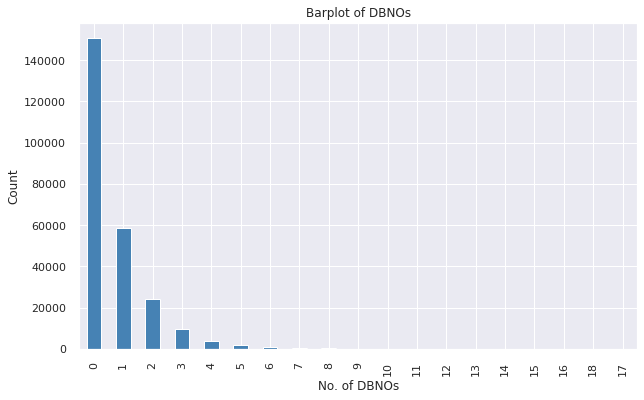

In [31]:
eda.bar_plot(train, 'DBNOs')

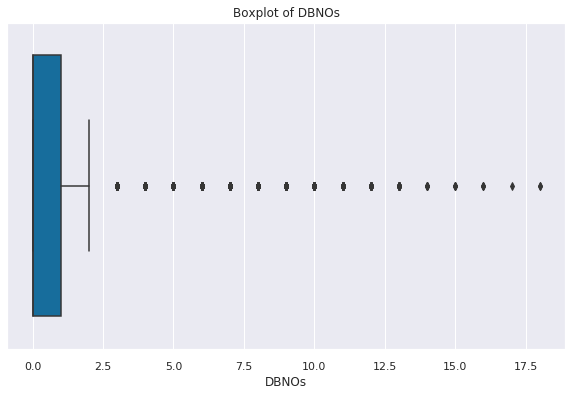

In [32]:
eda.box_plot(train, 'DBNOs')

In [33]:
eda.get_quantiles(df, 'DBNOs')

,DBNOs
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,3.0
0.99,5.0


> NOTES:

- Looks, like we have lot of outliers, but it could just show a highly skilled player vs. novice, and average players, as it's not normal to have more than 5 *knocked out* players. While, something like having ~25 *knocked out* players is highly unusual or sign of cheating.

In [34]:
train.query('DBNOs > 20')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc


> NOTES:

- Looks like this is an anomaly, as player was killed by death zone, played for more than half-hour, walked about ~ 2 kms, with no kills at all, could be sign of cheating.

##### assists - Number of enemy players this player damaged that were killed by teammates.

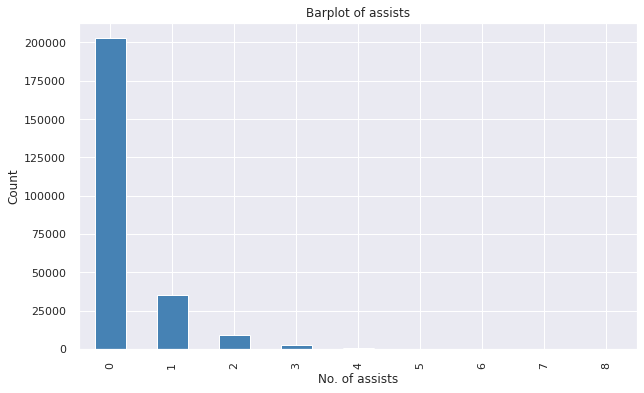

In [35]:
eda.bar_plot(train, 'assists')

In [36]:
eda.get_quantiles(df, 'assists')

,assists
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,1.0
0.99,3.0


Anything more than 8 assists looks unusual,

In [37]:
train[train['assists'] > 8]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc


> NOTES:

- Doesn't look like any unusual activity by player, as other stats are not that high to signal cheating.

##### boosts - Number of boost items used 🥤

![](https://gamepedia.cursecdn.com/battlegrounds_gamepedia_en/8/8f/Icon_Boost_EnergyDrink-New.png?version=f399cfe62074e8866aaec16812d0b5bc)

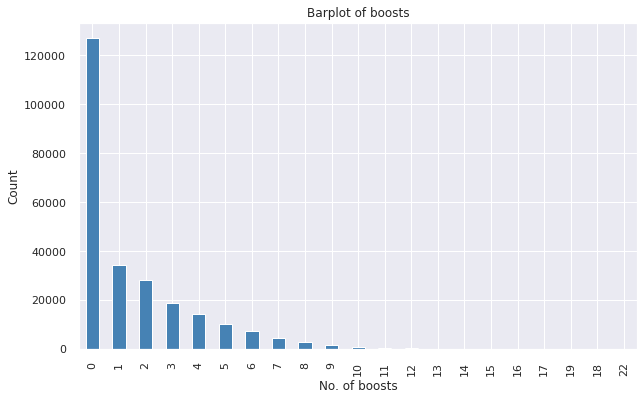

In [38]:
eda.bar_plot(train, 'boosts')

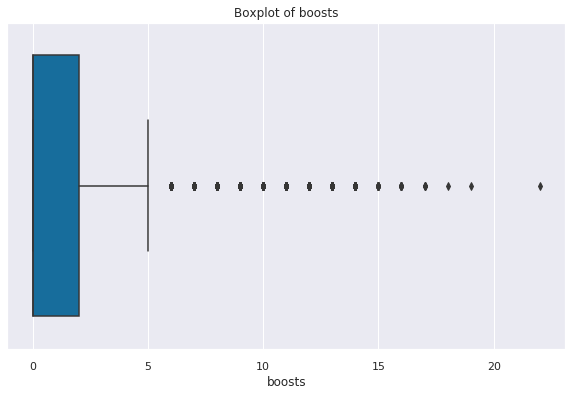

In [39]:
eda.box_plot(train, 'boosts')

> NOTES:

- When using boosting items (i.e. energy drinks) you run faster. They also help staying out of the zone (PUBG term) and loot more (meaning walking more).

- While it may not be unusual to use more than 5 boosts, but not more than 20.

In [40]:
eda.get_quantiles(train, 'boosts')

,boosts
0.01,0.0
0.25,0.0
0.50,0.0
0.75,2.0
0.95,6.0
0.99,9.0


In [41]:
train.query('boosts > 20')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
25808,4,1,22,824.5,byzone,1773,squad,2,4,1,3,8,146.125,Baltic_Main,6a6ca967-73c5-405e-9c85-e331266af444,steam,fdbfa4728af94bebbe4371f5f457510f,2,2160.0,0,0.0,0,1766.0,0,1712.0,11,26,0.96


> NOTES:

- Indeed, quite unusual amount may be or not caused due by player using cheats.

##### damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

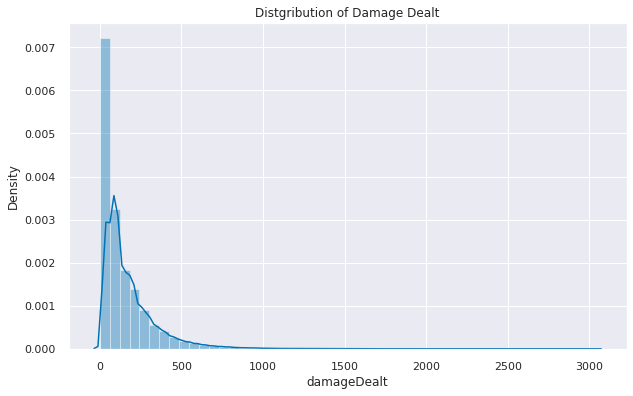

In [42]:
eda.hist_plot(train, 'damageDealt', 'Distgribution of Damage Dealt')

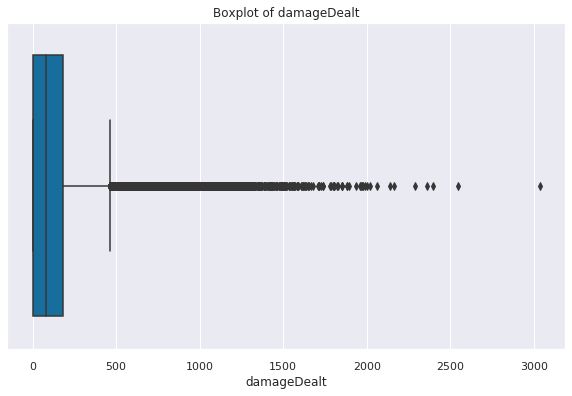

In [43]:
eda.box_plot(train, 'damageDealt')

> NOTES:

- Look's most damage dealt is ~ 750-ish, while above 2500 is just plain cheating.

In [44]:
eda.get_quantiles(train, 'damageDealt')

,damageDealt
0.01,0.000
0.25,0.000
0.50,82.125
0.75,184.500
0.95,444.500
0.99,746.500


In [45]:
train.query('damageDealt > 2500')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
15277,9,2,6,2546.0,byzone,2103,squad,0,8,2,1,5,58.21875,Desert_Main,f565f2e0-ebee-4a9b-8dd6-e8a0e557d89e,steam,d46eae56f0d40c9932f48a585b8f3f6,1,2670.0,0,222.125,0,2096.0,0,4460.0,6,26,0.96
33318,4,1,7,3036.0,alive,1891,squad,0,18,2,3,7,53.65625,Desert_Main,65c8a85b-aaa5-49bd-adc1-395dd27f829e,steam,d65ef5784aae41cfaf6eeaff57850033,0,3406.0,0,0.000,0,1891.0,0,2140.0,7,25,1.00


> NOTES:

- Looks like the cheater won the match 😠, has lots of `heals`, high `boosts`, with no headshot kills , but high `boosts`, indicative of using some kind of hacks or cheats.

##### duration - Amount of match duration in seconds

In [46]:
eda.get_quantiles(train, 'duration')

,duration
0.01,1223.0
0.25,1386.0
0.50,1628.0
0.75,1819.0
0.95,1946.0
0.99,2006.0


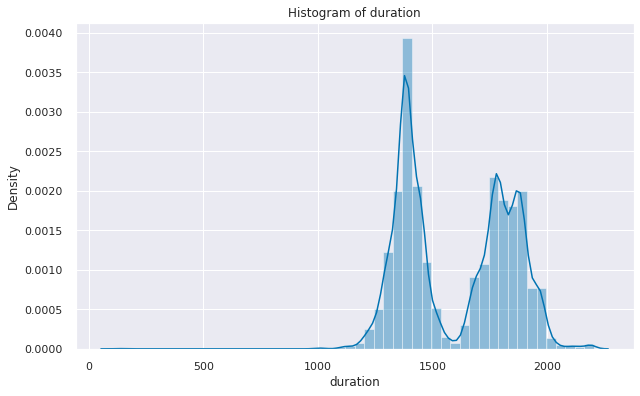

In [47]:
eda.hist_plot(train, 'duration')

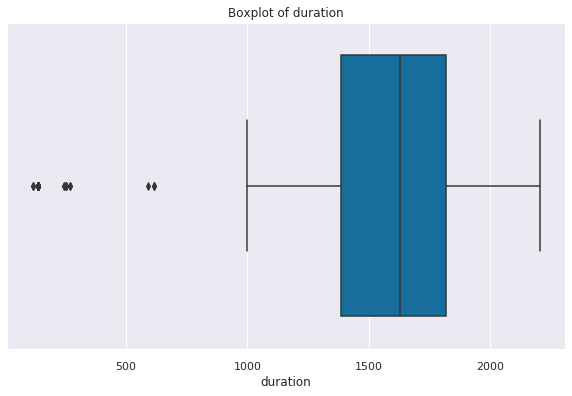

In [48]:
eda.box_plot(train, 'duration')

Let's investigate matches that are less than ~13 minutes in length

In [49]:
train.query('duration < 800')[['matchId', 'duration', 'mapName', 'gameMode', 'timeSurvived', 'deathType', 'platform', 'kills', 'maxPlace', 'walkDistance', 'winPlacePerc']].sample(10)

,matchId,duration,mapName,gameMode,timeSurvived,deathType,platform,kills,maxPlace,walkDistance,winPlacePerc
72488,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.875,byplayer,xbox,0,27,0.00,0.000000
12516,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.125,byplayer,xbox,0,27,0.00,0.041667
74826,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,137.125,byplayer,xbox,0,27,0.00,0.000000
43576,06b79959-c653-4dce-b9c1-249ee9f3b6ee,252,DihorOtok_Main,squad-fpp,252.125,alive,xbox,0,2,684.00,1.000000
195071,d10afd28-ccc6-4dbe-8920-851236df9849,269,Savage_Main,duo-fpp,261.250,byplayer,psn,0,2,198.00,0.000000
205881,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.000,byplayer,xbox,0,27,0.00,0.000000
32363,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,137.500,byplayer,xbox,0,27,0.00,0.000000
151317,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.375,byplayer,xbox,0,27,0.00,0.000000
33588,696a63c4-34c2-4456-9c61-d9f5440569d8,139,DihorOtok_Main,duo,136.875,byplayer,xbox,0,27,0.00,0.000000
154203,06b79959-c653-4dce-b9c1-249ee9f3b6ee,252,DihorOtok_Main,squad-fpp,252.125,alive,xbox,1,2,312.75,1.000000


> NOTES:

- There is definitely instance of cheating going on we can further narrow down to players who died with no `walkDistance`.

In [50]:
mask = (train['duration'] < 800) & (train['walkDistance'] == 0)
train[mask]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
10647,0,0,0,0.0,byplayer,139,duo,0,0,42,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,d35478dc4f94c139b7a6dcfde16a50e,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
12516,0,0,0,0.0,byplayer,139,duo,0,0,12,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,661dff1c6564d1e8b82da2593c311c1,0,0.0,0,0.0,0,136.125,0,0.0,0,27,0.041667
31913,0,0,0,0.0,byplayer,139,duo,0,0,19,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,4e7e8a1866114344af4e6d8cb1d9b0fd,0,0.0,0,0.0,0,137.500,0,0.0,0,27,0.000000
32363,0,0,0,0.0,byplayer,139,duo,0,0,18,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,197f8da48afd4e4392f242f35b81a65e,0,0.0,0,0.0,0,137.500,0,0.0,0,27,0.000000
33588,0,0,0,0.0,byplayer,139,duo,0,0,38,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,5cc8b1a282b4634a28c4589fd1e6f79,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000
39904,0,0,0,0.0,byplayer,139,duo,0,0,14,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,fb88287304d14e91a4490e328c53ac08,0,0.0,0,0.0,0,138.875,0,0.0,0,27,0.000000
44933,0,0,0,0.0,byplayer,139,duo,0,0,11,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,1788320098af47758d02c7dce8c101e0,0,0.0,0,0.0,0,136.500,0,0.0,0,27,0.041667
47981,0,0,0,0.0,byplayer,139,duo,0,0,20,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,fcc36f1982e4353bda376a8eb557402,0,0.0,0,0.0,0,137.250,0,0.0,0,27,0.000000
70525,0,0,0,0.0,byplayer,139,duo,0,0,5,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,fb58471e232443928b62f2b21a5f0b,0,0.0,0,0.0,0,137.625,0,0.0,0,27,0.833333
72488,0,0,0,0.0,byplayer,139,duo,0,0,34,0,0,0.0,DihorOtok_Main,696a63c4-34c2-4456-9c61-d9f5440569d8,xbox,6cd704b0683f44eba13d6f311e433048,0,0.0,0,0.0,0,136.875,0,0.0,0,27,0.000000


😡 Solid Cheating here, killing players off without anyone moving around, where is the fun in that. 

##### headshotKills - Number of enemy players killed with headshots

In [51]:
eda.get_quantiles(train, 'headshotKills')

,headshotKills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,1.0
0.99,2.0


> NOTES:

- Taking more than one or two headshots is indicative of highly skilled player, which could be used as predictor of target.

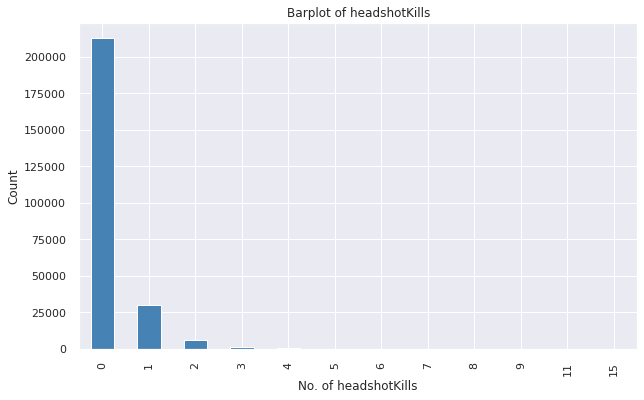

In [52]:
eda.bar_plot(train, 'headshotKills')

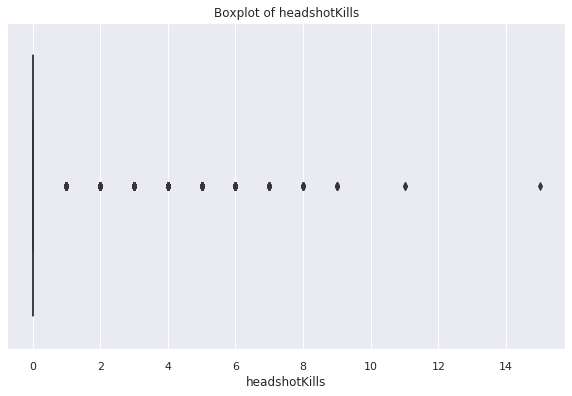

In [53]:
eda.box_plot(train, 'headshotKills')

In [54]:
train.query('headshotKills > 12')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
68085,15,0,6,1988.0,alive,1771,squad,15,11,1,5,17,517.0,Baltic_Main,774ccf7a-5511-4433-8be2-b8195bbfe13a,steam,b1d2e04b95534df78592d781db1e7ab4,1,4828.0,0,0.0,0,1771.0,0,1550.0,6,25,1.0


> NOTES:

- It's hard to tell if high headshot counts like above are unusual, or indicative of just highly skilled player mixed with cheaters using **Aim-bots**.

##### heals - Number of healing items used


In [55]:
eda.get_quantiles(train, 'heals')

,heals
0.01,0.0
0.25,0.0
0.50,0.0
0.75,2.0
0.95,8.0
0.99,15.0


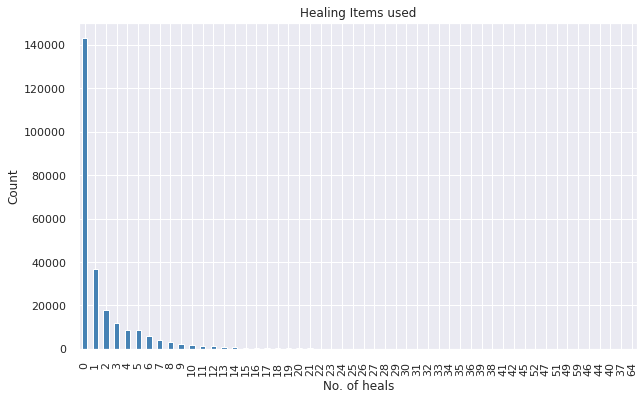

In [56]:
eda.bar_plot(train, 'heals', 'Healing Items used')

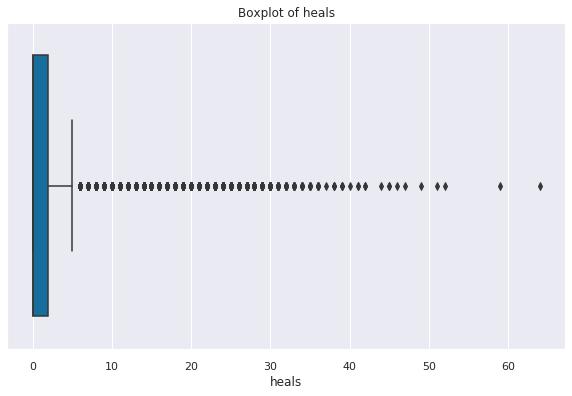

In [57]:
eda.box_plot(train, 'heals')

> NOTES:

- Since items are easily available and can be scavenged not unusual to have high amounts, while using high amounts of heals with no kills is indeed unusual. While, more than 50 is quite unusual amount of heals to take and not win the game.

In [58]:
train.query('heals > 50')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
14418,0,0,12,60.03125,byzone,1693,solo-fpp,0,59,18,1,1,32.656250,Baltic_Main,45b570a7-60fb-4322-bf25-8ba69e916665,steam,f6de20d126ef4ae8812ebfc807887f29,0,2266.0,0,0.0,0,1501.0,0,2538.0,5,98,0.948454
128442,2,0,5,163.00000,byplayer,1828,duo,0,52,12,1,2,15.953125,Baltic_Main,09e701c5-b343-48b9-84c3-2a6e8323cdbf,steam,7a96fe7f371643b2844893fd3d5be424,0,6468.0,0,0.0,0,1587.0,0,1026.0,6,48,0.914894
130517,6,0,2,590.00000,byzone,1737,squad,1,64,4,4,6,13.218750,Baltic_Main,648bbaf3-3b5b-4576-97d6-667eeb506d2c,kakao,de782457f6a4d4eab80c9f288b2e8f8,0,0.0,0,0.0,0,1394.0,0,2380.0,2,26,0.680000
240955,0,0,8,0.00000,byzone,1797,squad,0,51,49,0,0,0.000000,DihorOtok_Main,09175439-7b73-49d3-b7c0-dd2feba54a84,steam,93560f2eee814846b5f83ab5b9679a8,0,0.0,0,0.0,0,1345.0,0,1879.0,5,27,0.692308


> NOTES:

- Looks like they are cheating, with very few kills, and high amount of heals.

##### killStreaks - Max number of enemy players killed in a short amount of time

In [59]:
eda.get_quantiles(train, 'killStreaks')

,killStreaks
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,2.0
0.99,3.0


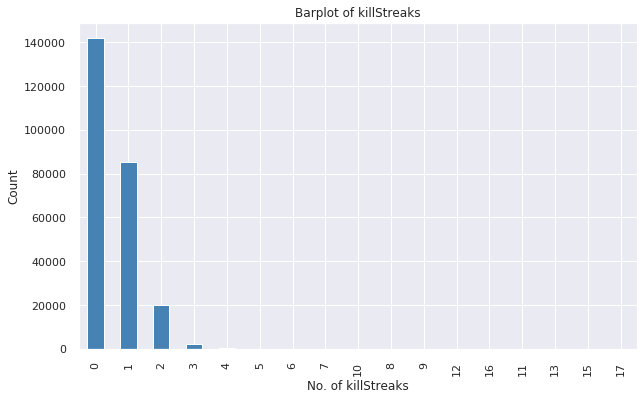

In [60]:
eda.bar_plot(train, 'killStreaks')

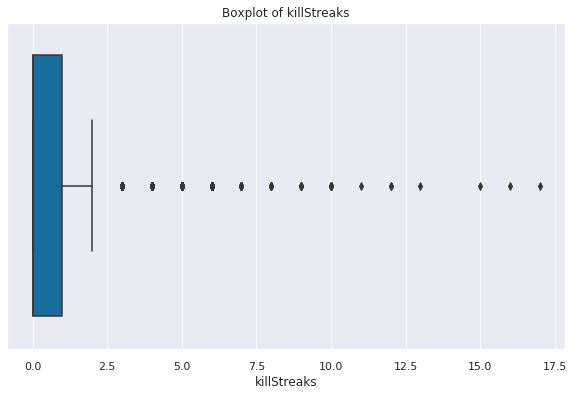

In [61]:
eda.box_plot(train, 'killStreaks')

> NOTES:

- Having high kill streaks is also unusual, as they are much harder to maintain even for a skilled player with assists of **Auto-Aim bots** or other hacks.

In [62]:
train.query('killStreaks > 15')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
131892,10,0,2,1854.0,byplayer,1675,squad,11,3,1,17,17,5.121094,DihorOtok_Main,752f849a-62e8-4f56-96c1-28f4267415f6,xbox,533a5f3f54274dc5b7ab5f3652cee164,1,1989.0,0,0.0,0,693.0,0,1064.0,6,27,0.961538
179056,10,0,2,1850.0,byplayer,1658,squad,1,0,1,16,17,36.593750,DihorOtok_Main,764651d1-44dd-4ab1-a337-b333631ed2d1,xbox,48cb145fe9fa4f2289d44beaa7914b5e,0,856.5,16,0.0,0,1331.0,0,2790.0,4,23,0.772727


##### kills - Number of enemy players killed

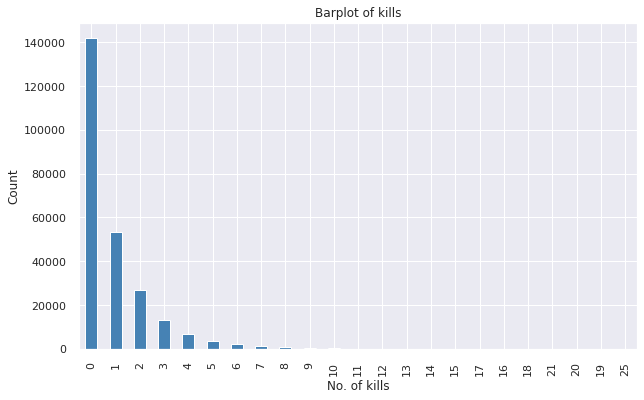

In [63]:
eda.bar_plot(train, 'kills')

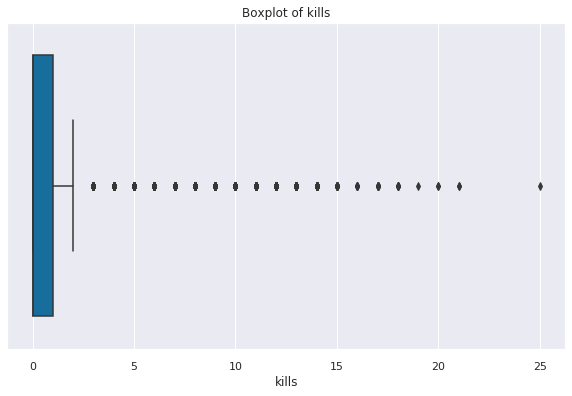

In [64]:
eda.box_plot(train, 'kills')

In [65]:
eda.get_quantiles(train, 'kills')

,kills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,1.0
0.95,4.0
0.99,7.0


> NOTES:

- Having high kills above 99% is indicative of your skills as a player, though cheaters might be mixed in.

##### longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.


In [66]:
eda.get_quantiles(train, 'longestKill')

,longestKill
0.01,0.000000
0.25,0.000000
0.50,0.000000
0.75,20.640625
0.95,124.875000
0.99,240.125000


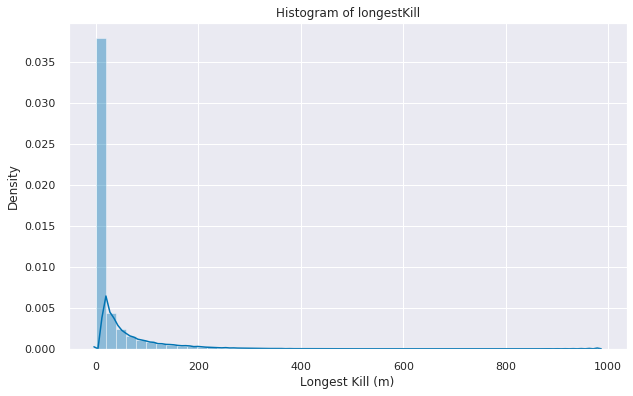

In [67]:
eda.hist_plot(train, 'longestKill', xlabel='Longest Kill (m)')

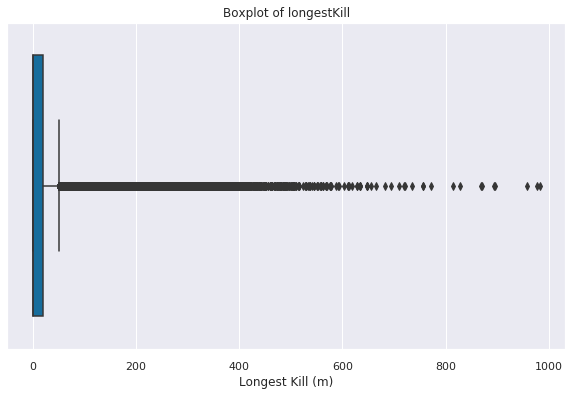

In [68]:
eda.box_plot(train, 'longestKill', xlabel='Longest Kill (m)')

##### revives - Number of times this player revived teammates

This attribute only applies to DBNO players, which means game mode would be `squad` or `duo` type.

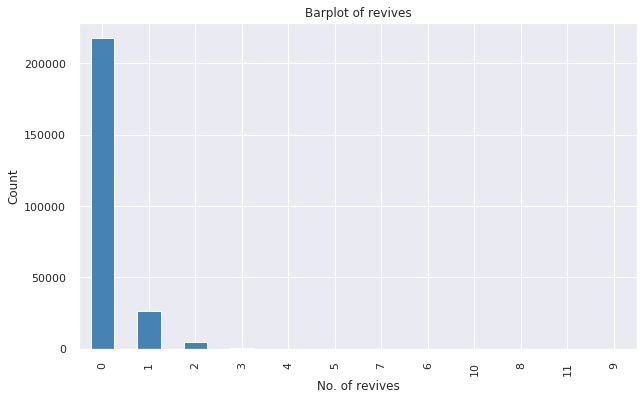

In [69]:
eda.bar_plot(train, 'revives')

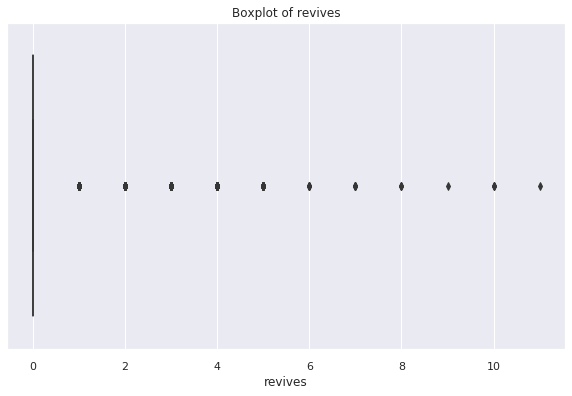

In [70]:
eda.box_plot(train, 'revives')

> NOTES:

- Definitely some of them are cheaters, when you have more than 10 revives, which is not possible when you are near enemy player that downed your teammate nearby, or under fire. 

In [71]:
train.query('revives >= 10')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
17022,13,0,0,0.000000,byzone,1305,squad,0,1,53,0,0,0.0,Savage_Main,dcaaf7aa-6251-4f0d-9c5c-d21f1eed4428,kakao,58b0ef0d5d79410a8263393a30464ede,10,0.0,0,139.25,3,977.00,0,439.75,2,27,0.538462
141661,3,0,0,0.000000,byplayer,1859,squad,0,0,70,0,0,0.0,DihorOtok_Main,d05598de-e237-44c3-9736-371a20503629,steam,f766d5e87c5e47aba860cd0a944ad987,11,0.0,0,0.00,0,467.25,0,557.50,2,24,0.130435
167584,12,0,6,208.375000,byplayer,1376,squad,2,13,16,1,2,26.0,Savage_Main,c4d5fc38-4439-424f-a86a-c77fd1f7bb26,steam,2ce8cc846b02415da39c71ff9d36b054,10,1103.0,0,0.00,1,1032.00,0,1596.00,5,25,0.666667
233079,10,0,2,30.203125,byplayer,1877,squad,0,4,53,0,0,0.0,Desert_Main,2010204d-3925-4664-82ec-14ef89667ea1,steam,44cc47f0e8e4c3f99d97da93498dd4,10,2518.0,0,0.00,0,1473.00,0,2818.00,2,25,0.625000


##### rideDistance - Total distance traveled in vehicles measured in meters

Since maps are big, and zones keep shrinking, players have to move around, those that are on the move and constantly get the loot have good chances of winning.

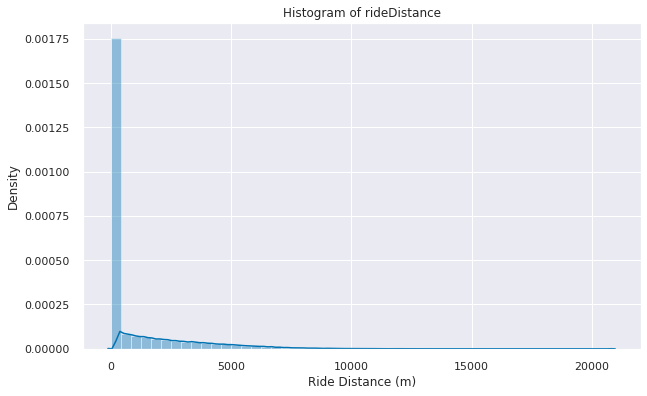

In [72]:
eda.hist_plot(train, 'rideDistance', xlabel = 'Ride Distance (m)')

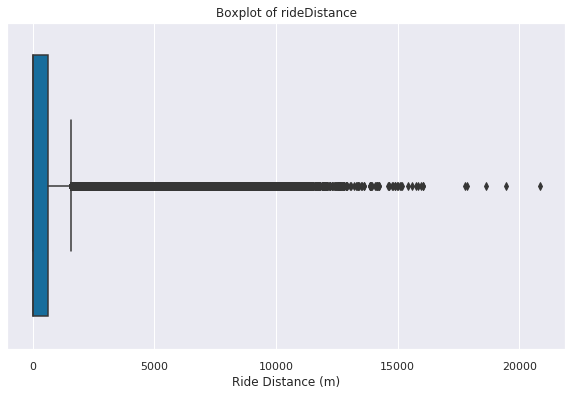

In [73]:
eda.box_plot(train, 'rideDistance', xlabel = 'Ride Distance (m)')

In [74]:
eda.get_quantiles(train, 'rideDistance')

,rideDistance
0.01,0.0
0.25,0.0
0.50,0.0
0.75,629.0
0.95,4724.0
0.99,7388.0


> NOTES:

- Anything greater than 20 km looks like players that are trolling around, let's see if they had any kills.

In [75]:
train.query('rideDistance > 20000')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
98314,0,0,9,774.5,alive,1908,solo,1,2,1,2,9,82.6875,Erangel_Main,9447cda2-6a78-4bff-b84a-2d54877f97f6,xbox,3f6ada953c3420e98b9da78914234f,0,20848.0,6,0.0,0,1908.0,0,1289.0,3,95,1.0


> NOTES:

- Indeed, except the first player, others didn't have any kills, as they were killed but surprisingly first player was a meat grinder, had 6 road kills, and one headshot.

There may be correlation between `roadKills vs. rideDistance`, after removing trolls.

In [76]:
train[['roadKills', 'rideDistance']].corr()

,roadKills,rideDistance
roadKills,1.000000,0.102952
rideDistance,0.102952,1.000000


- Very weak correlation, due to being poor strategy as it puts player into crosshairs.

##### roadKills - Number of kills while in a vehicle

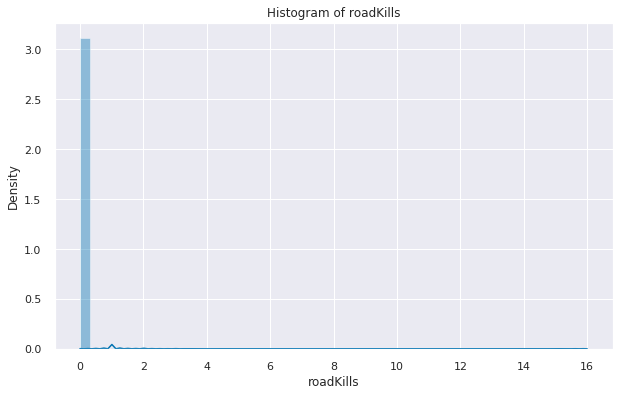

In [77]:
eda.hist_plot(train, 'roadKills')

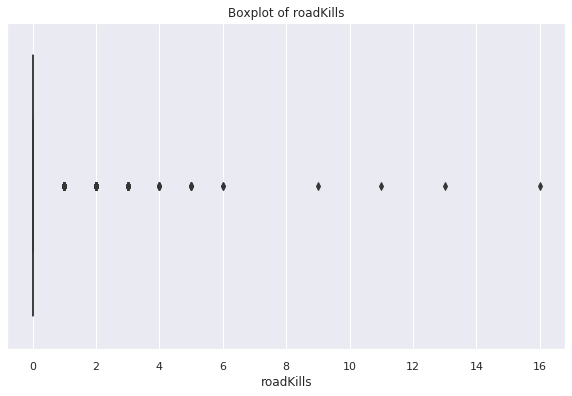

In [78]:
eda.box_plot(train, 'roadKills')

In [79]:
eda.get_quantiles(train, 'roadKills')

,roadKills
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,0.0
0.99,0.0


> NOTES:

- So, it is indeed unusual to have high `roadKills` as others would definitely shoot at you and chances of getting killed are high.

In [80]:
train.query('roadKills > 10')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
22936,8,0,0,1300.0,byplayer,1762,squad,0,0,1,13,13,5.769531,Erangel_Main,7c9bc90c-efe5-4a21-a0cb-3d0d6ee36186,xbox,eaa8b88fcfe04dd39c2fa07842641dd5,0,726.5,13,0.0,1,191.375,0,1.220703,0,27,0.269231
112008,5,0,1,1217.0,byplayer,2073,squad,0,1,1,5,11,5.449219,Erangel_Main,079dc24a-16be-43e1-bd05-37173bca4d27,xbox,16938b2e4b6340ecb979969f647d46b,0,4352.0,11,0.0,0,1334.000,0,1199.000000,7,26,0.720000
179056,10,0,2,1850.0,byplayer,1658,squad,1,0,1,16,17,36.593750,DihorOtok_Main,764651d1-44dd-4ab1-a337-b333631ed2d1,xbox,48cb145fe9fa4f2289d44beaa7914b5e,0,856.5,16,0.0,0,1331.000,0,2790.000000,4,23,0.772727


#####  swimDistance - Total distance traveled by swimming measured in meters

![](https://i.ytimg.com/vi/tQxzsE0DijQ/maxresdefault.jpg)

In [81]:
eda.get_quantiles(train, 'swimDistance')

,swimDistance
0.01,0.000000
0.25,0.000000
0.50,0.000000
0.75,0.000000
0.95,11.947656
0.99,126.500000


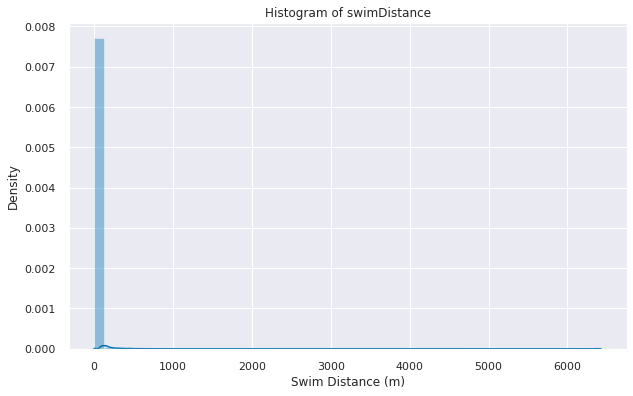

In [82]:
eda.hist_plot(train, 'swimDistance', xlabel='Swim Distance (m)')

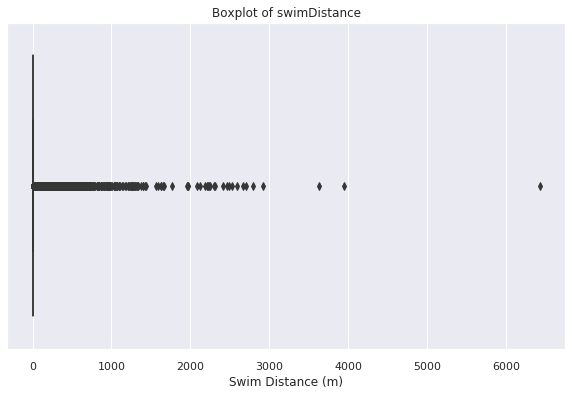

In [83]:
eda.box_plot(train, 'swimDistance', xlabel='Swim Distance (m)')

> NOTES:

- Most people don't swim, while those who swim may be swimming due to hide underneath the water.

##### teamKills - Number of times this player killed a teammate

`teamKills` could happen when players kill their teammates. This could happen for several reasons:

- Players could kill their teammates by accident such as throwing grenades at the wrong place.

- Players disconnect from the match. Teammates kill them to avoid enemies get their weapons and equipment.

- Players could kill their teammates because they behave badly.

- Players could kill their teammates just for fun.


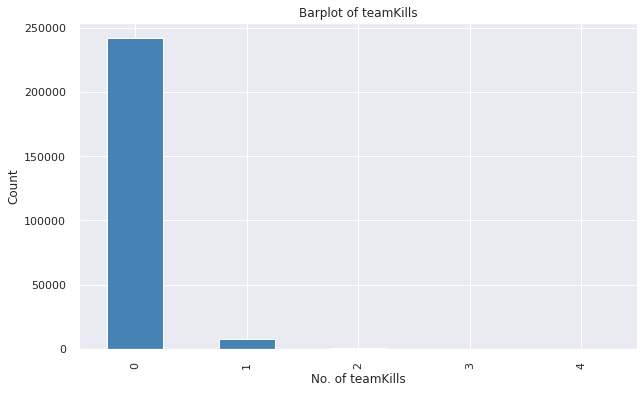

In [84]:
eda.bar_plot(train, 'teamKills')

In [85]:
train['teamKills'].value_counts()

0    241795
1      7774
2       439
3        42
4         5
Name: teamKills, dtype: int64

> NOTES:

- Definitely they have to be removed as no sane player would kill their teammates, accounting for accidental or mistakes, no more than 1 team mates, more than that would just be intentional.

In [86]:
train.query('teamKills >= 2')[['deathType', 'damageDealt', 'rideDistance', 'vehicleDestroys', 'kills', 'teamKills','winPlacePerc']].sample(15, random_state=42)

,deathType,damageDealt,rideDistance,vehicleDestroys,kills,teamKills,winPlacePerc
210445,byzone,152.62500,0.00,0,1,2,0.086957
133615,suicide,15.46875,4372.00,1,2,4,0.560000
216828,suicide,0.00000,0.00,0,0,2,0.734694
229967,suicide,181.00000,471.75,0,0,2,0.428571
180613,suicide,82.56250,4740.00,0,1,2,0.708333
238838,byplayer,0.00000,0.00,0,0,2,0.518519
99796,suicide,554.00000,3972.00,1,5,2,0.895833
115669,suicide,0.00000,2824.00,0,0,2,0.750000
59428,suicide,0.00000,0.00,0,0,2,0.153846
118533,suicide,243.87500,0.00,1,1,2,0.500000


> NOTES:
- Definitely, the `teamKills` more than or equal to 2 are just intentional as none of them intended to play seriously:
  - Those who have *vehicle destroyed* and died by *suicide* sound like players that didn't know how to drive
  - Some of them have no *damage dealt* or *kills* just died by *suicide* or *by player* or *zone*. 

##### timeSurvived - Amount of time survived measured in seconds

Since the game depends on last player survived without being killed, it implicitly means longer you survive higher your chances of winning, but not necessarily if you get killed, while it depends on amount of players in the game, map size, and player skills.

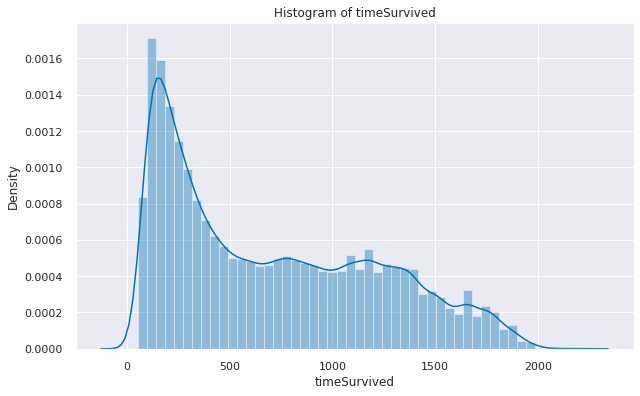

In [87]:
eda.hist_plot(train, 'timeSurvived')

##### vehicleDestroys - Number of vehicles destroyed

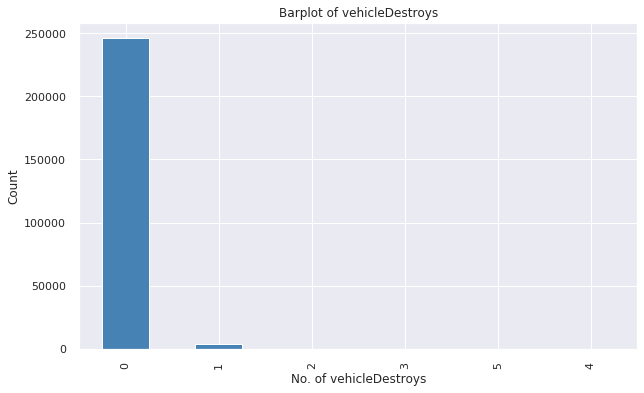

In [88]:
eda.bar_plot(train, 'vehicleDestroys')

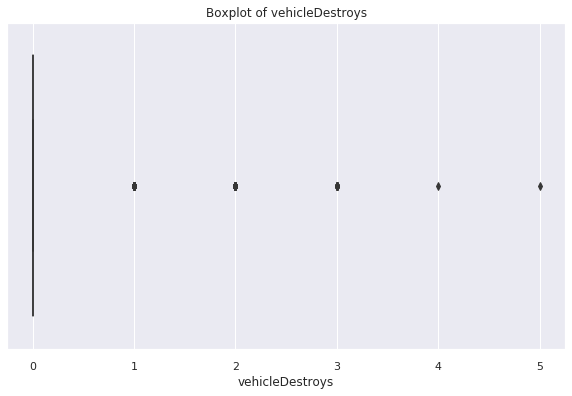

In [89]:
eda.box_plot(train, 'vehicleDestroys')

In [90]:
eda.get_quantiles(train, 'vehicleDestroys')

,vehicleDestroys
0.01,0.0
0.25,0.0
0.50,0.0
0.75,0.0
0.95,0.0
0.99,1.0


> NOTES:

- Looks like most people don't destroy vehicle, those that destroy could use that to their advantage if not they died by *suicide*.

##### walkDistance - Total distance traveled on foot measured in meters

In [91]:
eda.get_quantiles(train, 'walkDistance')

,walkDistance
0.01,0.000
0.25,184.125
0.50,792.500
0.75,1985.000
0.95,3314.000
0.99,4256.000


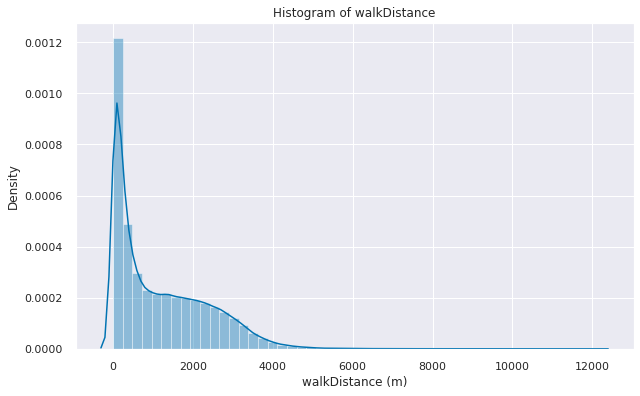

In [92]:
eda.hist_plot(train, 'walkDistance', xlabel='walkDistance (m)')

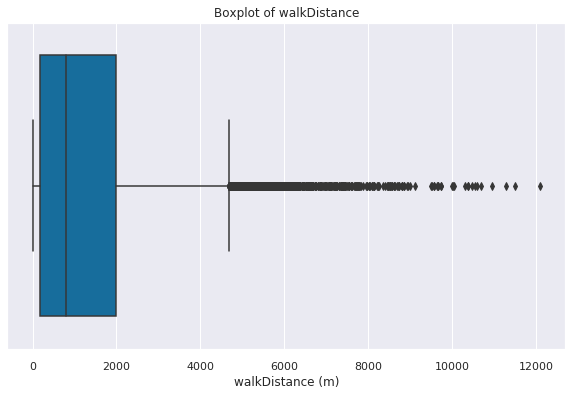

In [93]:
eda.box_plot(train, 'walkDistance', xlabel='walkDistance (m)')

> NOTES:

- We definitely have marathon runners, did they made any kills or not ?
  - Let's narrow down to those who didn't kill and just ran across the map eventually getting killed by another player, suicide or zone.

##### ☮️ The Peace lovers 🕊️



In [94]:
mask = (train['walkDistance'] > 10000) & (train['kills'] == 0)
train[mask]

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
7851,0,1,7,90.9375,byplayer,1566,squad,0,13,41,0,0,0.0,Baltic_Main,7177602e-e772-49bd-a6be-7c81b9feff17,steam,60e7011b28c9496bb0f5c8ee8927b01,0,3278.000000,0,29.156250,0,1522.0,0,10944.0,4,27,0.923077
20970,0,0,6,0.0000,byplayer,1756,squad,0,17,48,0,0,0.0,Baltic_Main,2af46407-03a9-4419-8f55-6d15b3f6a787,steam,944c0e58f4f84df88562c2eb35c817c2,0,314.000000,0,36.625000,0,1573.0,0,10392.0,5,26,0.880000
140021,0,0,4,0.0000,byplayer,1842,duo,0,5,49,0,0,0.0,Desert_Main,aad3a872-8e0d-4d0b-a13f-0e2f43063cdd,kakao,712093c17a0d40aba4c6b0c9dcccdd2,0,0.006191,0,2.230469,0,1339.0,0,10304.0,5,45,0.613636
195809,0,0,3,0.0000,byplayer,1847,solo,0,0,42,0,0,0.0,Baltic_Main,508f9620-73fb-4aa5-aae6-62807362df10,kakao,1a1243d6172c4d3093ea7b51018ac222,0,0.002117,0,77.625000,0,1524.0,0,10024.0,6,97,0.906250
236522,0,0,0,0.0000,byplayer,1659,squad,0,0,41,0,0,0.0,Erangel_Main,694742d9-deff-4929-bdb8-31c51aafbbe7,xbox,ecd0e281e1da461cb71e5f9151857b6b,0,0.004009,0,15.218750,0,1149.0,0,10488.0,4,25,0.625000
236644,1,0,1,99.6250,byplayer,1842,duo,0,5,48,0,0,0.0,Desert_Main,aad3a872-8e0d-4d0b-a13f-0e2f43063cdd,kakao,0a3a2d99bef044e0b5c89247920dce29,0,0.001355,0,5.964844,0,1339.0,0,10688.0,4,45,0.613636


WOW! Interestingly, if you just run around the map without any kills, you still have high chance of winning the game, by being last few players alive, as their `killPlace` is lowest, with lots of `heals`.

##### weaponsAcquired - Number of weapons picked up

In [95]:
eda.get_quantiles(train, 'weaponsAcquired')

,weaponsAcquired
0.01,0.0
0.25,2.0
0.50,4.0
0.75,5.0
0.95,8.0
0.99,11.0


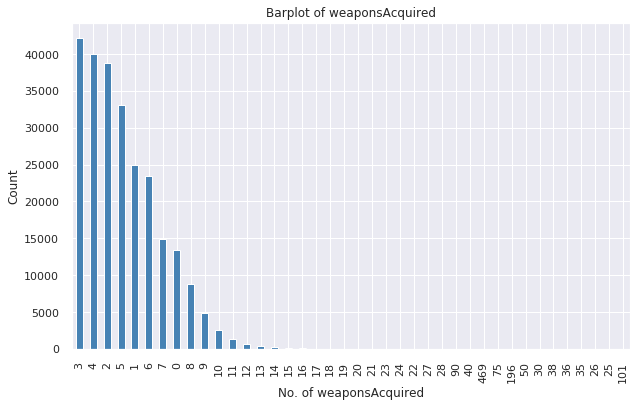

In [96]:
eda.bar_plot(train, 'weaponsAcquired')

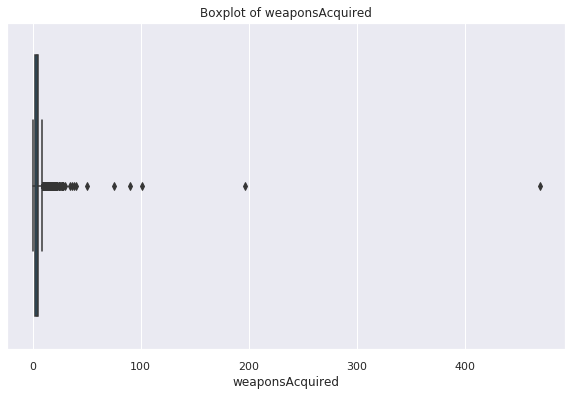

In [97]:
eda.box_plot(train, 'weaponsAcquired')

It would be unusual to even acquire more than 50 weapons and not win or have high kills in the game.

In [98]:
train.query('weaponsAcquired > 35')[['weaponsAcquired', 'platform', 'deathType', 'duration', 'kills', 'killStreaks', 'damageDealt', 'heals', 'boosts', 'winPlacePerc']]

,weaponsAcquired,platform,deathType,duration,kills,killStreaks,damageDealt,heals,boosts,winPlacePerc
55621,50,steam,byzone,1827,0,0,0.000,26,8,0.886598
66160,101,steam,byplayer,1677,0,0,126.250,1,2,0.800000
78533,36,steam,byplayer,1763,0,0,74.000,5,1,1.000000
90956,40,steam,byplayer,1744,0,0,127.375,7,4,0.631579
94555,469,steam,byzone,1724,1,1,144.625,2,1,0.695652
143191,196,steam,byplayer,1382,0,0,0.000,2,1,0.586207
147770,75,kakao,byplayer,1690,2,1,293.000,2,1,0.678571
155597,38,steam,byplayer,1856,0,0,0.000,0,3,0.280000
224973,90,steam,byplayer,1538,2,2,73.250,6,3,0.916667


We did found the cheater, who has 469 `weaponsAcquired`, with 1 kill, got killed by a zone, they might be trying out the cheats. Some of the console players may be legit., while PC players are doubtful.

In [99]:
train.query('playerId == "account.4fb8997e7eee47c6b716afb2847e0ae7"')

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc


##### killPlace - Ranking in match of number of enemy players killed ⚠️ May cause leakage

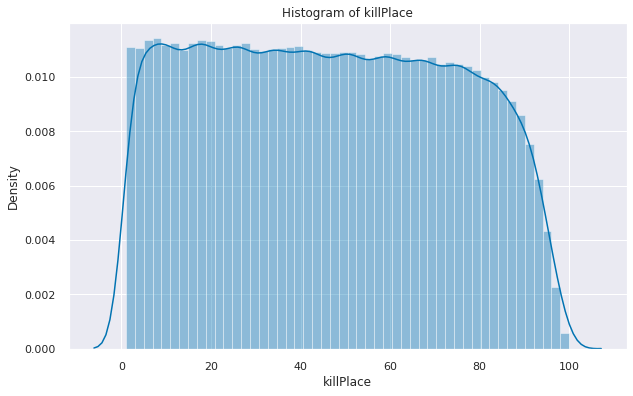

In [100]:
eda.hist_plot(train, 'killPlace')

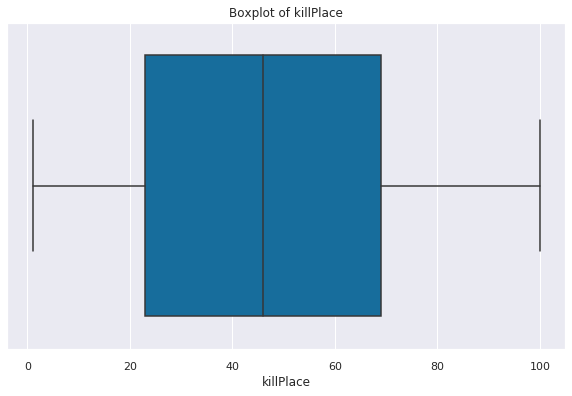

In [101]:
eda.box_plot(train, 'killPlace')

##### ⭐ winPlacePerc - Winning probability [Target]

In [102]:
train['winPlacePerc'].describe().to_frame()

,winPlacePerc
count,250055.000000
mean,0.467275
std,0.309677
min,0.000000
25%,0.192308
50%,0.452632
75%,0.739130
max,1.000000


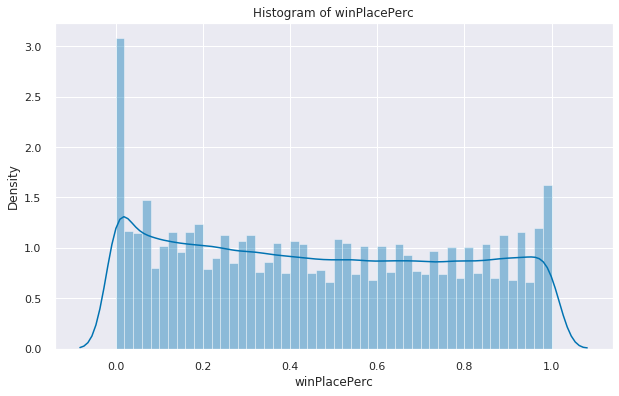

In [103]:
eda.hist_plot(train, 'winPlacePerc')

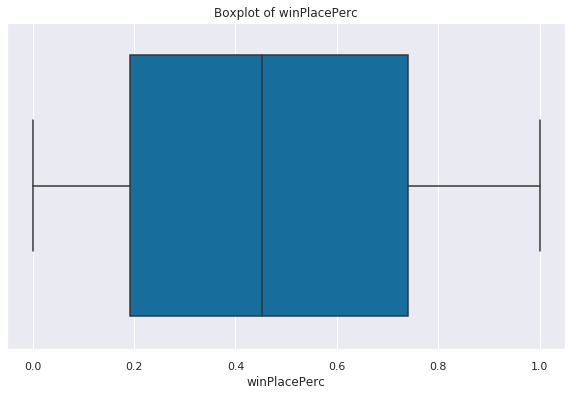

In [104]:
eda.box_plot(train, 'winPlacePerc')

#### Categorical Columns

##### deathType - The way by which this player died, or alive if they didn't ⚠️ Causes leakage

In [105]:
train['deathType'].value_counts()

byplayer    220634
byzone       16550
suicide       6818
alive         5965
logout          88
Name: deathType, dtype: int64

In [106]:
train.groupby('deathType')['winPlacePerc'].describe()

,count,mean,std,min,25%,50%,75%,max
deathType,,,,,,,,
alive,5965.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
byplayer,220634.0,0.439689,0.299078,0.000000,0.172414,0.416667,0.692308,1.0
byzone,16550.0,0.618855,0.295043,0.000000,0.440000,0.703704,0.857143,1.0
logout,88.0,0.998632,0.009373,0.923077,1.000000,1.000000,1.000000,1.0
suicide,6818.0,0.519072,0.276296,0.000000,0.319149,0.536842,0.750000,1.0


In [107]:
train[train['deathType'] == 'alive']['winPlacePerc'].value_counts()

1.0    5965
Name: winPlacePerc, dtype: int64

> NOTES:

- Indeed it causes a leakage

- It would be wise to remove players that logged out as it doesn't count as an actual engagement to play the game.

##### gameMode - Game mode played 

The standard modes are: 
 - solo or solo-fpp (FPP - First Person Player)
 - duo or duo-fpp
 - squad or squad-fpp 
 - and other modes are from events or custom matches.

In [108]:
train['gameMode'].value_counts()

squad        140602
duo           55976
solo          27224
squad-fpp     16195
duo-fpp        6518
solo-fpp       3540
Name: gameMode, dtype: int64

> NOTES:

- Looks like most players like to play in third person perspective: squad based matches, followed by duo and solo matches. This trend is similar in first person perspective matches as well.


##### mapName - There are 4 main type of maps:
- Erangel (Alpha Map) - a Russian Map
- Desert (Miramar) - a Central American map
- Savage (Sanhok) - a Southeast Asian forest map
- Snow (Vikendi or Dihorotok) - an Adriatic island snow map

In [109]:
train['mapName'].value_counts()

Savage_Main       122864
Baltic_Main        46806
Erangel_Main       31785
Desert_Main        30896
DihorOtok_Main     17704
Name: mapName, dtype: int64

> NOTES:

- Looks like most players like Jungle based map, followed by Baltic, which looks codename for Snow based map, than urban based map, lastly Desert oriented map. 

- It looks like we can further simplify the categories by grouping maps into their types, that would be reflective of actual playing environment.

#### [Pairwise Analysis](#Pairwise-Analysis)

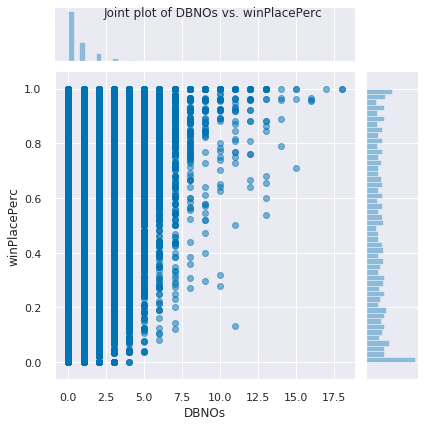

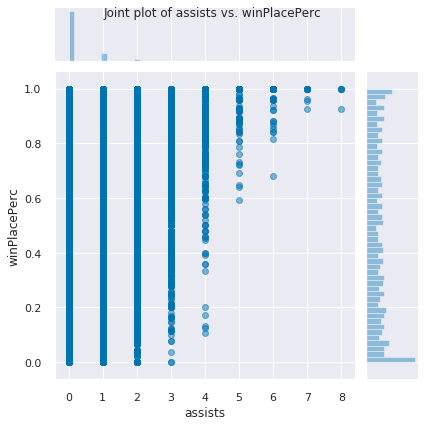

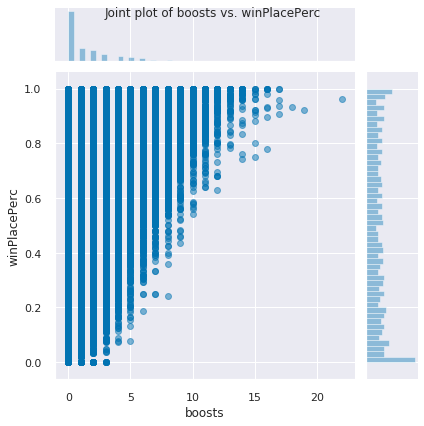

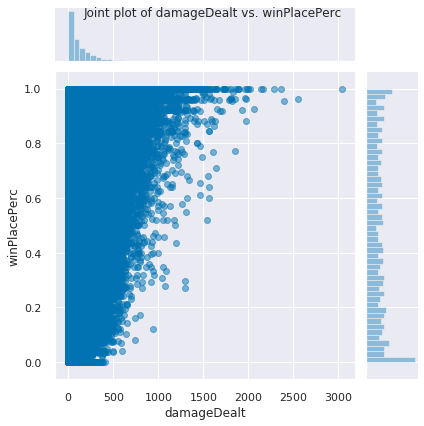

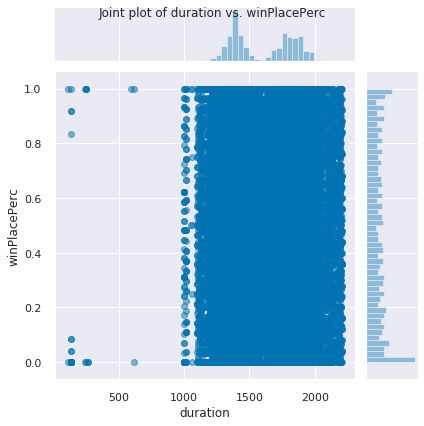

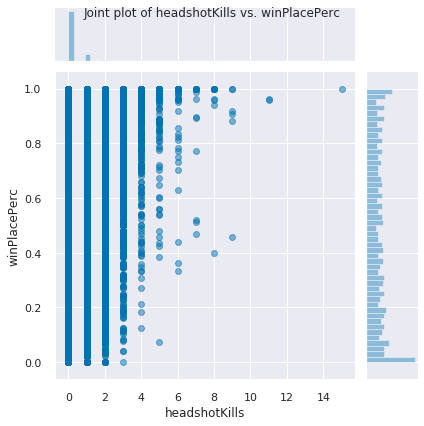

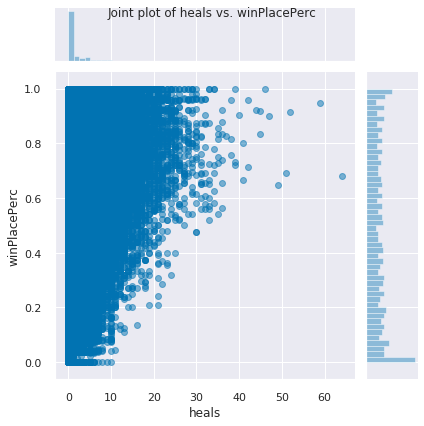

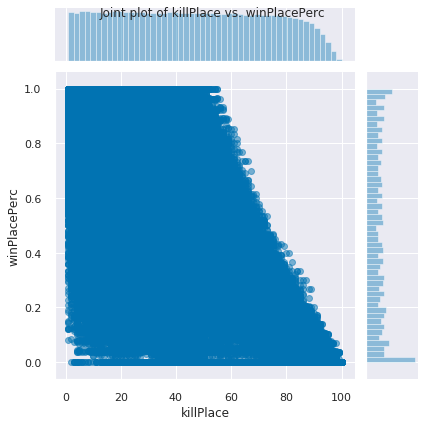

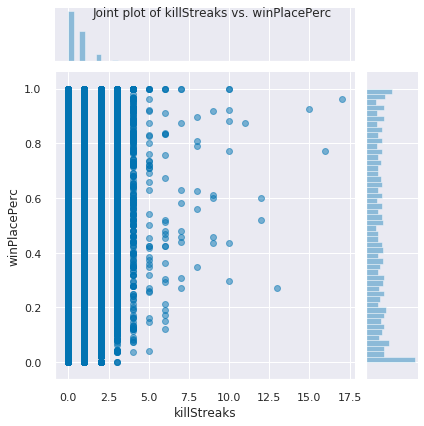

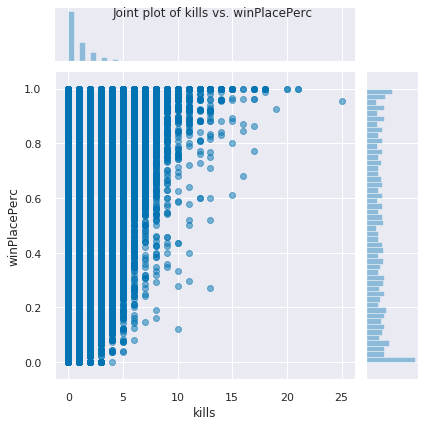

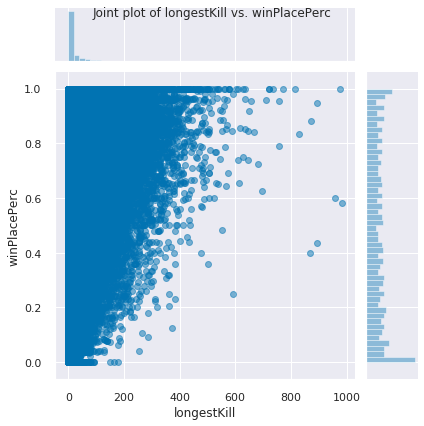

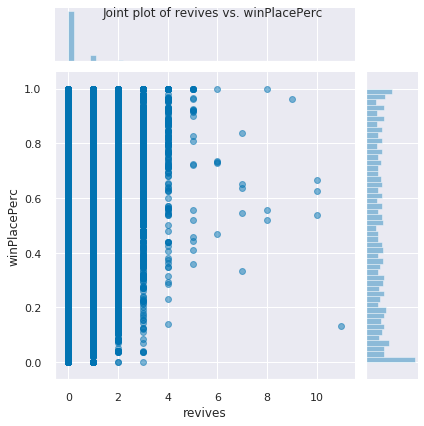

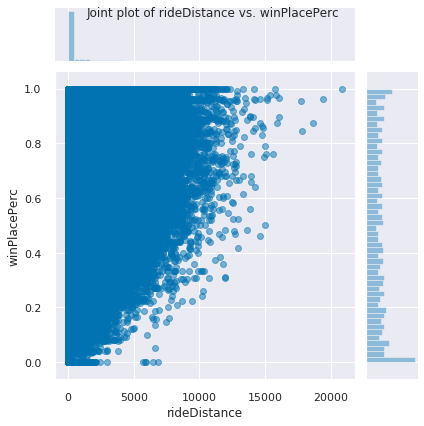

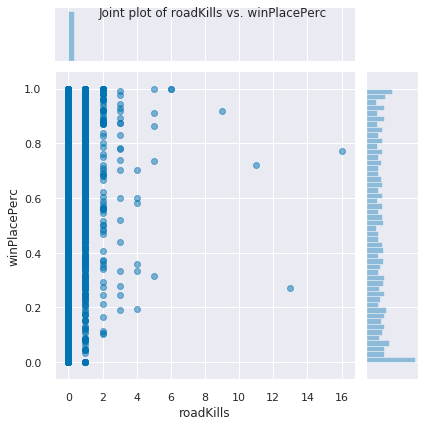

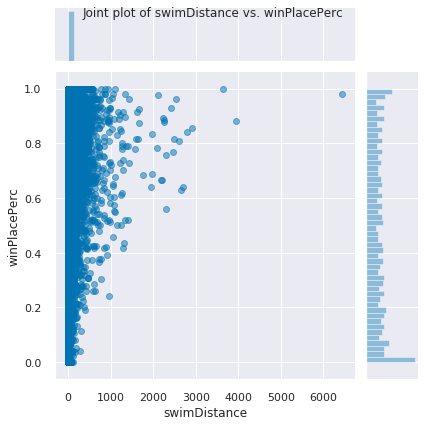

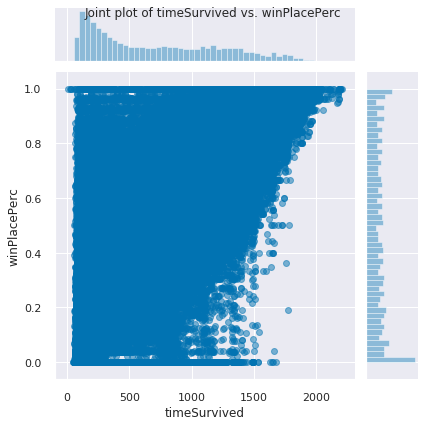

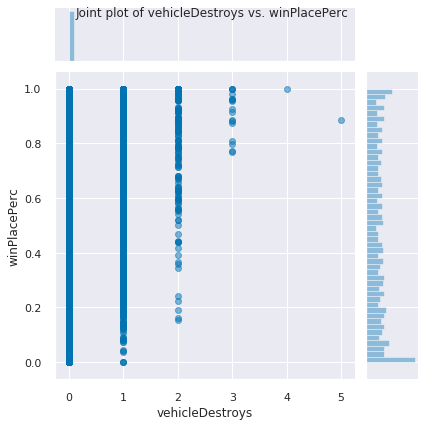

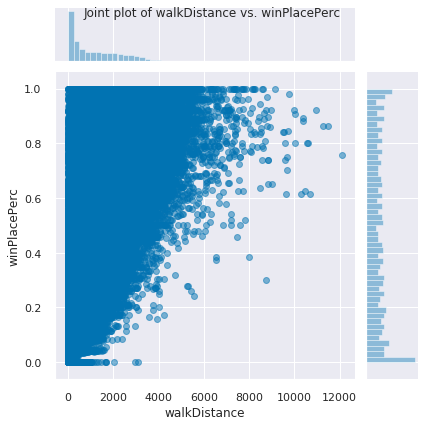

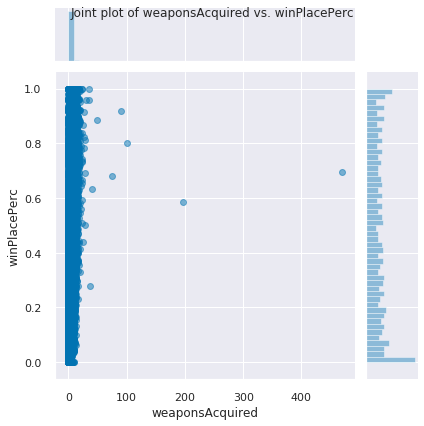

In [110]:
exclude_cols = ['maxPlace', 'winPlacePerc', 'teamKills']
numeric_cols = eda.get_numeric_columns(train)
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
target = 'winPlacePerc'

for col in numeric_cols:
    eda.joint_plot(train, col, target, alpha=0.5)

> NOTES:

- Notice the outliers:

  - DBNOs > 20
  - assists > 8
  - boosts > 20
  - damageDealt > 2500
  - duration < 800
  - heals > 50
  - revives > 15
  - rideDistance > 20000
  - roadKills > 12
  - weaponsAcquired > 100

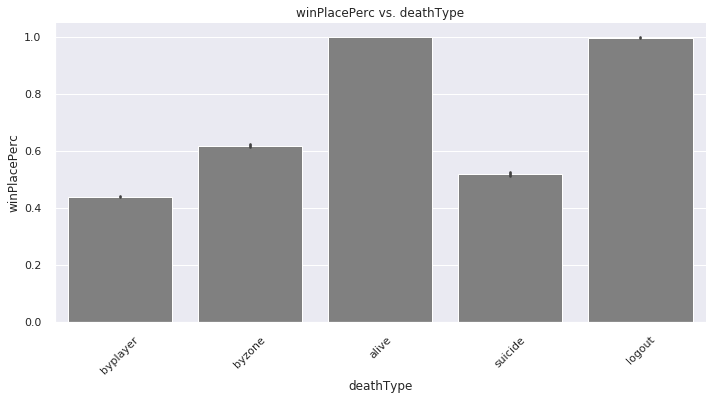

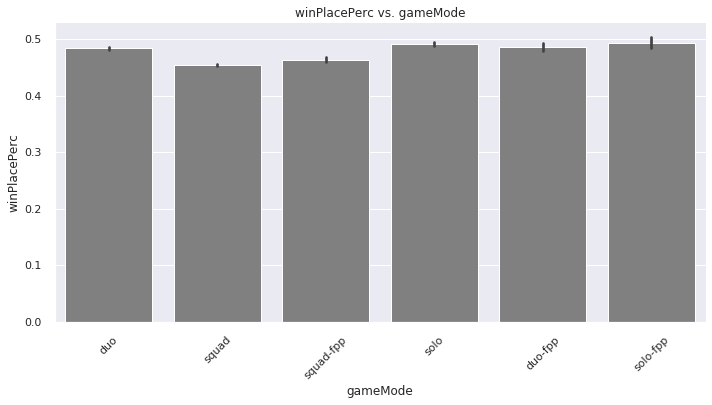

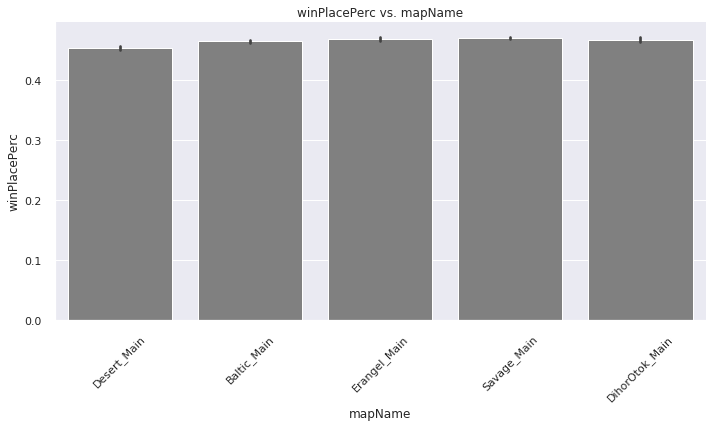

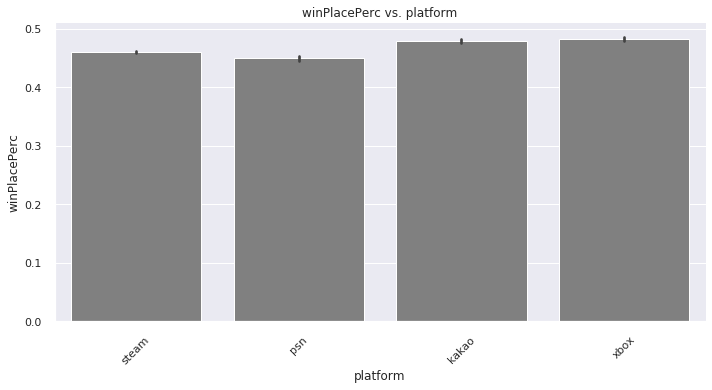

In [111]:
eda.plot_categorical_reg(train, 'winPlacePerc')

> NOTES:

- Besides `deathType` which has leakage, neither the *map type* nor any particular *platform* have any overwhelming advantage.



#### [Correlations](#Correlations)

In [112]:
numeric_cols = eda.get_numeric_columns(train)
df = train.copy()
df.head()

,DBNOs,assists,boosts,damageDealt,deathType,duration,gameMode,headshotKills,heals,killPlace,killStreaks,kills,longestKill,mapName,matchId,platform,playerId,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired,maxPlace,winPlacePerc
0,1,0,1,297.50000,byplayer,1877,duo,1,5,21,2,2,15.328125,Desert_Main,2f1575b3-429f-4157-9912-99541deb6e17,steam,f0ddcf1483b43d8b64e9a9a6c7de989,0,3294.0,0,0.0,0,1061.0,0,2080.0,2,48,0.638298
1,0,0,1,24.59375,byplayer,1668,squad,0,0,69,0,0,0.000000,Baltic_Main,4c7d6119-11f6-4956-bf5e-05ca8fd07659,steam,828b2b9895cd4be6b53e28ddc87fb4cb,0,0.0,0,0.0,0,469.5,0,846.5,6,22,0.142857
2,0,0,1,0.00000,byplayer,1876,squad,0,2,37,0,0,0.000000,Erangel_Main,a2cf4074-7f23-4af0-9ec3-d6a09ddb3956,psn,5e7bce16a39a4ad8aabadc55c8c59585,0,3422.0,0,0.0,0,1267.0,0,998.0,11,23,0.681818
3,1,0,3,146.37500,byplayer,1917,squad,0,3,27,1,1,14.890625,Desert_Main,12e94db2-7b6f-4a51-bbf5-2d2fdc3830fb,steam,d96c6cff614e4757bcbfe04dc430f3dd,0,6588.0,0,0.0,0,1554.0,0,1762.0,7,25,0.666667
4,1,1,2,129.37500,byplayer,1383,squad,0,3,19,1,2,11.867188,Savage_Main,364cf8af-57f2-461c-8b01-66c8b0f53c03,steam,84937113f82541a4a8e09eb1147805a6,0,1450.0,0,0.0,0,743.5,0,913.5,3,26,0.520000


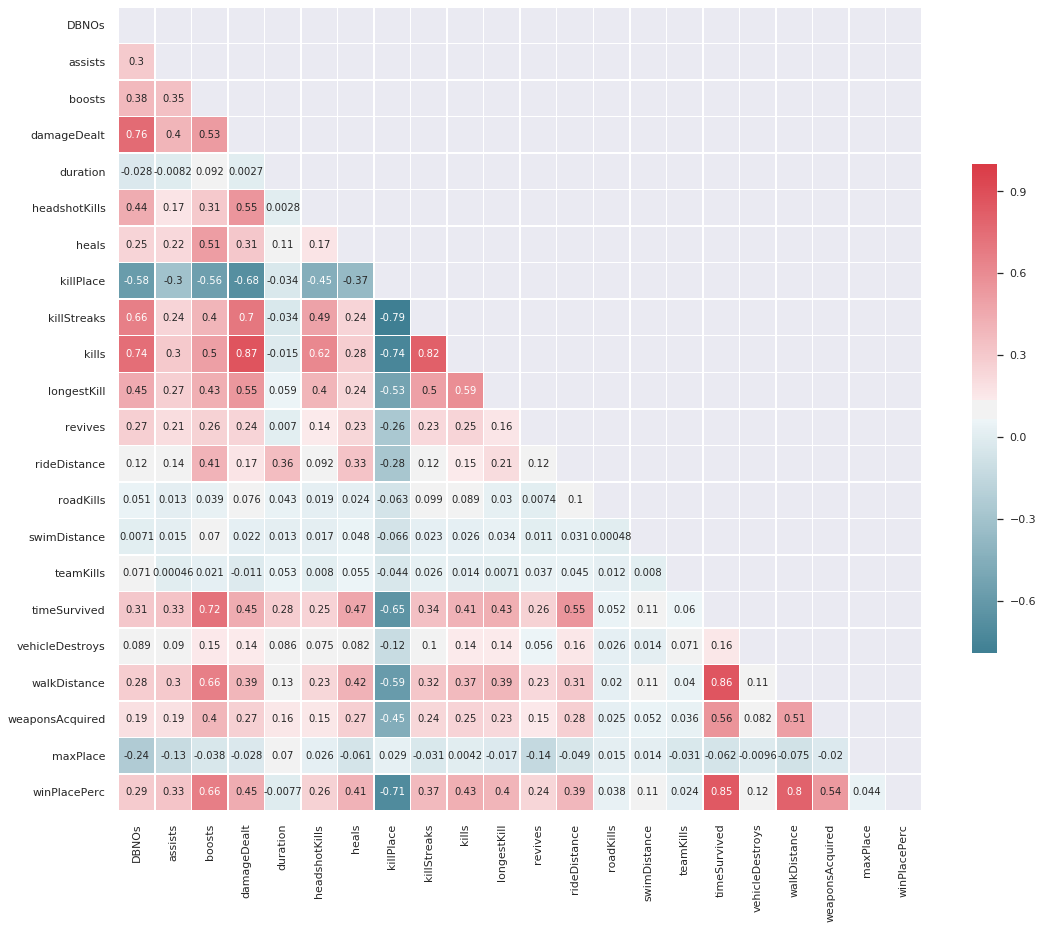

In [113]:
eda.plot_correlation_heatmap(df[numeric_cols], figsize=(18, 18))

### [Baseline](#Contents)

#### [Mean](#Contents)

In [114]:
train['winPlacePerc'].describe()

count    250055.000000
mean          0.467275
std           0.309677
min           0.000000
25%           0.192308
50%           0.452632
75%           0.739130
max           1.000000
Name: winPlacePerc, dtype: float64

Since it's a uniform distribution, we would expect to have 50-50 chances of winning. 

#### [Linear Regression](#Contents)

##### Numerical Features

In [115]:
target = 'winPlacePerc'
numeric_cols = eda.get_numeric_columns(train)
exclude_cols = ['winPlacePerc', 'maxPlace']
num_features = [col for col in numeric_cols if col not in exclude_cols]
num_features

['DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killPlace',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [116]:
# 1. Split X, y

X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, num_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250055, 20)
X_val : (83344, 20)
X_test : (83283, 20)
y_train: (250055,)
y_val : (83344,)
y_test : (83283,)



In [117]:
X_train.head()

,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,1,0,1,297.50000,1877,1,5,21,2,2,15.328125,0,3294.0,0,0.0,0,1061.0,0,2080.0,2
1,0,0,1,24.59375,1668,0,0,69,0,0,0.000000,0,0.0,0,0.0,0,469.5,0,846.5,6
2,0,0,1,0.00000,1876,0,2,37,0,0,0.000000,0,3422.0,0,0.0,0,1267.0,0,998.0,11
3,1,0,3,146.37500,1917,0,3,27,1,1,14.890625,0,6588.0,0,0.0,0,1554.0,0,1762.0,7
4,1,1,2,129.37500,1383,0,3,19,1,2,11.867188,0,1450.0,0,0.0,0,743.5,0,913.5,3


In [118]:
# 2. Fit Model

from sklearn.linear_model import LinearRegression

num_model = LinearRegression()
num_model.fit(X_train, y_train)

# 3. Print Metrics
eda.get_reg_metrics(num_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.8364
MSE: 0.0157
RMSE: 0.1252
MAE: 0.0930
-------- VALIDATION SET --------
R^2: 0.8353
MSE: 0.0158
RMSE: 0.1255
MAE: 0.0932


#### Numerical + Categorical features

In [119]:
### Don't select Ids which are useless, and have high cardinality to them
categorical_cols = eda.get_categorical_columns(train, min_card=1, max_card=12)
categorical_cols

['deathType', 'gameMode', 'mapName', 'platform']

In [120]:
target = 'winPlacePerc'
combined_features = categorical_cols + num_features
combined_features

['deathType',
 'gameMode',
 'mapName',
 'platform',
 'DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killPlace',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [121]:
# 1. Split X, y

X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, combined_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250055, 24)
X_val : (83344, 24)
X_test : (83283, 24)
y_train: (250055,)
y_val : (83344,)
y_test : (83283,)



In [122]:
X_train.head()

,deathType,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,byplayer,duo,Desert_Main,steam,1,0,1,297.50000,1877,1,5,21,2,2,15.328125,0,3294.0,0,0.0,0,1061.0,0,2080.0,2
1,byplayer,squad,Baltic_Main,steam,0,0,1,24.59375,1668,0,0,69,0,0,0.000000,0,0.0,0,0.0,0,469.5,0,846.5,6
2,byplayer,squad,Erangel_Main,psn,0,0,1,0.00000,1876,0,2,37,0,0,0.000000,0,3422.0,0,0.0,0,1267.0,0,998.0,11
3,byplayer,squad,Desert_Main,steam,1,0,3,146.37500,1917,0,3,27,1,1,14.890625,0,6588.0,0,0.0,0,1554.0,0,1762.0,7
4,byplayer,squad,Savage_Main,steam,1,1,2,129.37500,1383,0,3,19,1,2,11.867188,0,1450.0,0,0.0,0,743.5,0,913.5,3


In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

# 2. Make Pipeline
lr_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)

lr_model.fit(X_train, y_train)

# 3. Print Metrics
eda.get_reg_metrics(lr_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.8516
MSE: 0.0142
RMSE: 0.1193
MAE: 0.0864
-------- VALIDATION SET --------
R^2: 0.8513
MSE: 0.0142
RMSE: 0.1193
MAE: 0.0865


#### k - Best Features

In [124]:
# 1. Do One-Hot encoding of categorical columns first 
X_train_encoded = lr_model.named_steps['onehotencoder'].transform(X_train)
X_val_encoded = lr_model.named_steps['onehotencoder'].transform(X_val)
X_train_encoded.head()

,deathType_byplayer,deathType_byzone,deathType_alive,deathType_suicide,deathType_logout,gameMode_duo,gameMode_squad,gameMode_squad-fpp,gameMode_solo,gameMode_duo-fpp,gameMode_solo-fpp,mapName_Desert_Main,mapName_Baltic_Main,mapName_Erangel_Main,mapName_Savage_Main,mapName_DihorOtok_Main,platform_steam,platform_psn,platform_kakao,platform_xbox,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killPlace,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,297.50000,1877,1,5,21,2,2,15.328125,0,3294.0,0,0.0,0,1061.0,0,2080.0,2
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,24.59375,1668,0,0,69,0,0,0.000000,0,0.0,0,0.0,0,469.5,0,846.5,6
2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0.00000,1876,0,2,37,0,0,0.000000,0,3422.0,0,0.0,0,1267.0,0,998.0,11
3,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,3,146.37500,1917,0,3,27,1,1,14.890625,0,6588.0,0,0.0,0,1554.0,0,1762.0,7
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,2,129.37500,1383,0,3,19,1,2,11.867188,0,1450.0,0,0.0,0,743.5,0,913.5,3


Text(0, 0.5, '$R^2$')

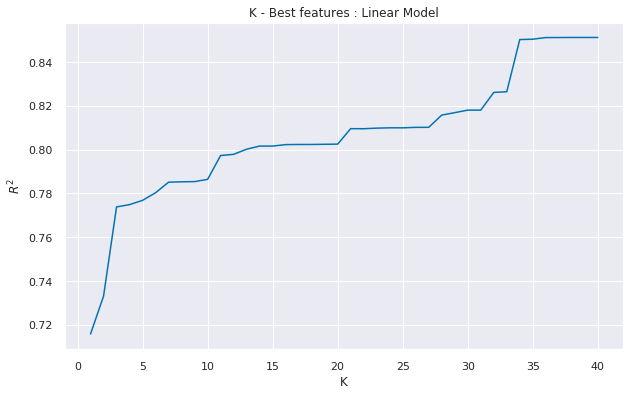

In [125]:
#  2. Plot to find k-best features
results = eda.find_k_best_features(lr_model[-1], X_train_encoded, X_val_encoded, y_train, y_val)
plt.figure(figsize=(10, 6))
plt.plot(results['K'], results['R_SQUARE'])
plt.title('K - Best features : Linear Model')
plt.xlabel('K')
plt.ylabel('$R^2$')

> NOTES:

- Looks like 35 is when $R^2$ plateaus.
- Let's print out those features

In [126]:
# Select the 35 features that gave best score
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=37)
X_train_selected = selector.fit_transform(X_train_encoded, y_train)
X_val_selected = selector.transform(X_val_encoded)

X_train_selected.shape, X_val_selected.shape

((250055, 37), (83344, 37))

In [127]:
# Which features were selected?
all_names = X_train_encoded.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
print('\n')
print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
deathType_byplayer
deathType_byzone
deathType_alive
deathType_suicide
deathType_logout
gameMode_duo
gameMode_squad
gameMode_solo
gameMode_duo-fpp
gameMode_solo-fpp
mapName_Desert_Main
mapName_Baltic_Main
mapName_Savage_Main
platform_steam
platform_psn
platform_kakao
platform_xbox
DBNOs
assists
boosts
damageDealt
duration
headshotKills
heals
killPlace
killStreaks
kills
longestKill
revives
rideDistance
roadKills
swimDistance
teamKills
timeSurvived
vehicleDestroys
walkDistance
weaponsAcquired



Features not selected:
gameMode_squad-fpp
mapName_Erangel_Main
mapName_DihorOtok_Main


**Without leakage features**

In [128]:
leakage_features = ['deathType', 'killPlace']
no_leakage_features = [col for col in combined_features if col not in leakage_features]
no_leakage_features

['gameMode',
 'mapName',
 'platform',
 'DBNOs',
 'assists',
 'boosts',
 'damageDealt',
 'duration',
 'headshotKills',
 'heals',
 'killStreaks',
 'kills',
 'longestKill',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'timeSurvived',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired']

In [129]:
# 2. Split X, y
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, no_leakage_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250055, 22)
X_val : (83344, 22)
X_test : (83283, 22)
y_train: (250055,)
y_val : (83344,)
y_test : (83283,)



In [130]:
X_train.head()

,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,duo,Desert_Main,steam,1,0,1,297.50000,1877,1,5,2,2,15.328125,0,3294.0,0,0.0,0,1061.0,0,2080.0,2
1,squad,Baltic_Main,steam,0,0,1,24.59375,1668,0,0,0,0,0.000000,0,0.0,0,0.0,0,469.5,0,846.5,6
2,squad,Erangel_Main,psn,0,0,1,0.00000,1876,0,2,0,0,0.000000,0,3422.0,0,0.0,0,1267.0,0,998.0,11
3,squad,Desert_Main,steam,1,0,3,146.37500,1917,0,3,1,1,14.890625,0,6588.0,0,0.0,0,1554.0,0,1762.0,7
4,squad,Savage_Main,steam,1,1,2,129.37500,1383,0,3,1,2,11.867188,0,1450.0,0,0.0,0,743.5,0,913.5,3


In [131]:
# 3. Make Pipeline & Train Model
lr_model = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)

lr_model.fit(X_train, y_train)

# 4. Print Metrics
eda.get_reg_metrics(lr_model, X_train, X_val, y_train, y_val, verbose=True);


-------- TRAINING SET --------
R^2: 0.8128
MSE: 0.0180
RMSE: 0.1340
MAE: 0.0950
-------- VALIDATION SET --------
R^2: 0.8140
MSE: 0.0178
RMSE: 0.1334
MAE: 0.0949


MAE increased, which was to be expected, as those features caused leakage of target, now let's see how Tree based model perform, with no leakage features.

#### [Random Forest](#Contents)

In [132]:
# 1. Split with no leakage features
X_train, X_val, X_test, y_train, y_val, y_test = eda.subset_features(train, validate, test, no_leakage_features, target)

print(f'''
X_train : {X_train.shape}
X_val : {X_val.shape}
X_test : {X_test.shape}
y_train: {y_train.shape}
y_val : {y_val.shape}
y_test : {y_test.shape}
''')


X_train : (250055, 22)
X_val : (83344, 22)
X_test : (83283, 22)
y_train: (250055,)
y_val : (83344,)
y_test : (83283,)



In [133]:
X_train.head()

,gameMode,mapName,platform,DBNOs,assists,boosts,damageDealt,duration,headshotKills,heals,killStreaks,kills,longestKill,revives,rideDistance,roadKills,swimDistance,teamKills,timeSurvived,vehicleDestroys,walkDistance,weaponsAcquired
0,duo,Desert_Main,steam,1,0,1,297.50000,1877,1,5,2,2,15.328125,0,3294.0,0,0.0,0,1061.0,0,2080.0,2
1,squad,Baltic_Main,steam,0,0,1,24.59375,1668,0,0,0,0,0.000000,0,0.0,0,0.0,0,469.5,0,846.5,6
2,squad,Erangel_Main,psn,0,0,1,0.00000,1876,0,2,0,0,0.000000,0,3422.0,0,0.0,0,1267.0,0,998.0,11
3,squad,Desert_Main,steam,1,0,3,146.37500,1917,0,3,1,1,14.890625,0,6588.0,0,0.0,0,1554.0,0,1762.0,7
4,squad,Savage_Main,steam,1,1,2,129.37500,1383,0,3,1,2,11.867188,0,1450.0,0,0.0,0,743.5,0,913.5,3


In [134]:
from sklearn.ensemble import RandomForestRegressor

rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

)

rf_model.fit(X_train, y_train)

# 4. Print Metrics
eda.get_reg_metrics(rf_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9806
MSE: 0.0019
RMSE: 0.0431
MAE: 0.0277
-------- VALIDATION SET --------
R^2: 0.8611
MSE: 0.0133
RMSE: 0.1153
MAE: 0.0748


#### Tune the model real quick

In [135]:
# from sklearn.model_selection import RandomizedSearchCV

# pipeline = make_pipeline(
#     ce.TargetEncoder(), 
#     RandomForestRegressor(random_state=42)
# )

# param_distributions = {
#     'randomforestregressor__n_estimators': np.arange(50, 500, 10), 
#     'randomforestregressor__min_samples_split': np.arange(2, 10, 1)
# }

# search = RandomizedSearchCV(
#     pipeline, 
#     param_distributions=param_distributions,
#     n_iter=3,
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-1
# )

# search.fit(X_train, y_train)
# print(search.best_params_)
# print(search.best_score_)

```
Fitting 3 folds for each of 3 candidates, totalling 9 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  7.6min remaining: 15.2min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  7.6min remaining:  9.5min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed: 10.8min remaining:  8.6min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 12.5min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed: 17.1min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 18.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 18.3min finished

{'randomforestregressor__n_estimators': 230, 'randomforestregressor__min_samples_split': 8}
0.8052210978164809
```

#### Re-run Model w/ Best Params

In [136]:
rf_model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_estimators=200,
                          min_samples_split=8,                          
                          n_jobs=-1, random_state=42)

)

rf_model.fit(X_train, y_train)

# Print Metrics
eda.get_reg_metrics(rf_model, X_train, X_val, y_train, y_val, verbose=True);

-------- TRAINING SET --------
R^2: 0.9589
MSE: 0.0039
RMSE: 0.0627
MAE: 0.0387
-------- VALIDATION SET --------
R^2: 0.8629
MSE: 0.0131
RMSE: 0.1145
MAE: 0.0742


#### Feature Importances

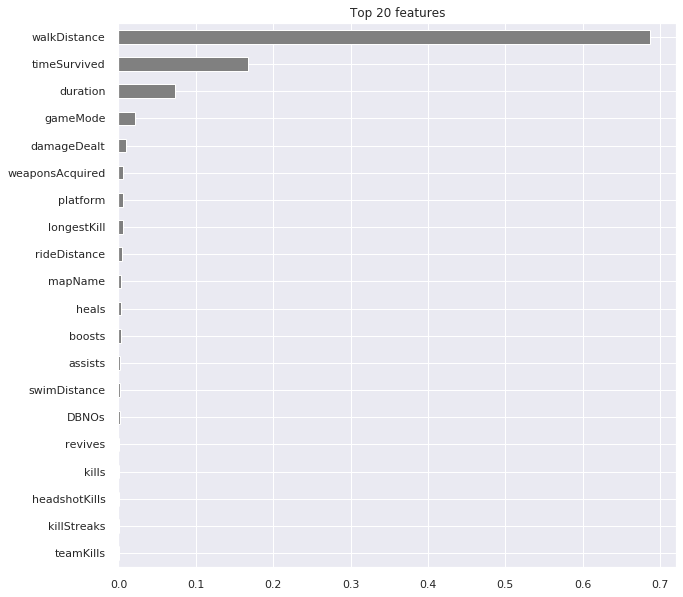

In [137]:
# Encode the categorical columns first
encoder = rf_model[0]
X_val_encoded = encoder.transform(X_val)

# Get feature names
feature_names = X_val_encoded.columns.tolist()

# Get feature importances
rf = rf_model.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, feature_names)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

#### Permutaiton Importances

In [138]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    rf_model[-1], 
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_encoded, y_val)


eli5.show_weights(
    permuter, 
    top=None, # show the permutation importances for all feature
    feature_names=feature_names
)

Weight,Feature
0.6096 ± 0.0075,walkDistance
0.4291 ± 0.0023,timeSurvived
0.1453 ± 0.0011,duration
0.0475 ± 0.0005,gameMode
0.0115 ± 0.0003,platform
0.0094 ± 0.0003,rideDistance
0.0049 ± 0.0002,mapName
0.0041 ± 0.0002,longestKill
0.0038 ± 0.0003,weaponsAcquired
0.0035 ± 0.0008,boosts


#### Save Train, Validate and Test Sets

In [139]:
to_save = {'train':train, 'validate':validate, 'test':test}
clean_dat_dir = '../datasets/clean-data'

for k, v in to_save.items():
    save_path = os.path.join(clean_dat_dir, f'{k}.csv')
    helper.save_data_frame(v, save_path)

Data Frame saved @:../datasets/clean-data/train.csv
Data Frame saved @:../datasets/clean-data/validate.csv
Data Frame saved @:../datasets/clean-data/test.csv
